In [1]:
import os
import sys

print(os.path.dirname(sys.executable))

c:\Users\JENMOSQU\Documents\PERSONAL\TESIS\Probabilistic-Electricity-Demand-\venv\Scripts


In [2]:
import os
directory = os.getcwd()  
directory = directory.split('src')
path = directory[0]
%cd $path
%pwd

c:\Users\JENMOSQU\Documents\PERSONAL\TESIS\Probabilistic-Electricity-Demand-


'c:\\Users\\JENMOSQU\\Documents\\PERSONAL\\TESIS\\Probabilistic-Electricity-Demand-'

In [ ]:
#https://www.kaggle.com/code/konradb/ts-1a-smoothing-methods/notebook
#https://www.kaggle.com/code/konradb/ts-1b-prophet/notebook
#https://www.kaggle.com/code/konradb/ts-2-linear-vision?scriptVersionId=101499413
#https://www.kaggle.com/code/konradb/ts-1b-prophet#Using-covariates

In [3]:
# Libraries utilities
# ==============================================================================
import numpy as np
from collections import Counter
from tqdm import tqdm
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

# Importar las bibliotecas necesarias
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



#Model
# ==============================================================================
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
#ARDRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from scipy import stats


#Modules from repo
from src.Utilities import utilities as tool


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración options.display
# ==============================================================================
pd.set_option('display.max_rows', 5000)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000
pd.options.display.max_colwidth = 5000
pd.options.display.max_dir_items = 5000
pd.options.display.width = 5000
pd.options.display.float_format = '{:.1f}'.format

c:\Users\JENMOSQU\Documents\PERSONAL\Master\cod\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
df = pd.read_parquet('merge.parquet')
df.describe()

demanda     pib   pop  inflacion  temp  prep
count        204.0   204.0 204.0      204.0 204.0 204.0
mean  5110643830.6 60556.5   1.4        4.1  22.4   6.1
std    660733003.2 10269.3   0.2        1.7   0.4   2.0
min   3708680497.6 40782.3   1.1        1.5  21.5   1.2
25%   4556807354.2 51086.2   1.2        3.0  22.1   4.6
50%   5085152022.6 61976.6   1.4        3.8  22.4   6.2
75%   5647889563.4 69306.5   1.6        5.0  22.7   7.4
max   6490084008.4 84385.2   1.7        9.0  23.7  11.3

In [12]:
df['fecha'] = pd.to_datetime(df['fecha'])
year_df = df[df['fecha'].dt.year == 2005]
year_df['pop'].sum()# 2021 año de la población

year_df['pib'].iloc[0:3].sum() # 2021 trimestres  pib

year_df['pib'].iloc[3:6].sum()

# # sort by date & time
# df.sort_values(by=['fecha'], axis=0, ascending=True, inplace=True)
# df.reset_index(inplace=True, drop=True)

128496.95449627201

### Deduplicating cleanning

In [13]:
df.drop_duplicates(subset='fecha', keep='last', inplace=True)
df = df.set_index('fecha')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2005-01-01 to 2021-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   demanda    204 non-null    float64
 1   pib        204 non-null    float64
 2   pop        204 non-null    float64
 3   inflacion  204 non-null    float64
 4   temp       204 non-null    float64
 5   prep       204 non-null    float64
dtypes: float64(6)
memory usage: 11.2 KB


### Extracting Time Features

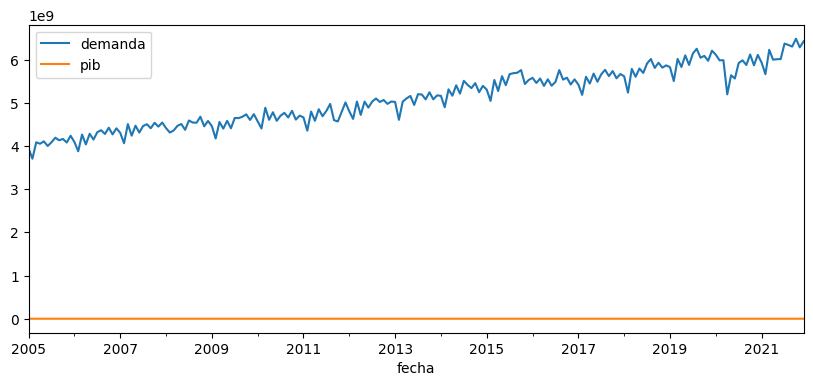

In [14]:
df['dow'] = df.index.dayofweek  #día de la semana [0: Lunes, 1: Martes, 2: Miércoles, 3: Jueves, 4: Viernes, 5: Sábado, 6: Domingo]
df['trimestre'] = df.index.quarter #(1-4) correspondiente al trimestre del año de cada fecha

# Preparación del dato
# Paso 3: cambiar la frecuencia de los datos a mensual ('MS')
datos = df.asfreq('MS')

# Paso 4: graficar las variables de interés
fig, ax = plt.subplots(figsize=(10, 4))
datos['demanda'].plot(ax=ax, label='demanda')
datos['pib'].plot(ax=ax, label='pib')
ax.legend();

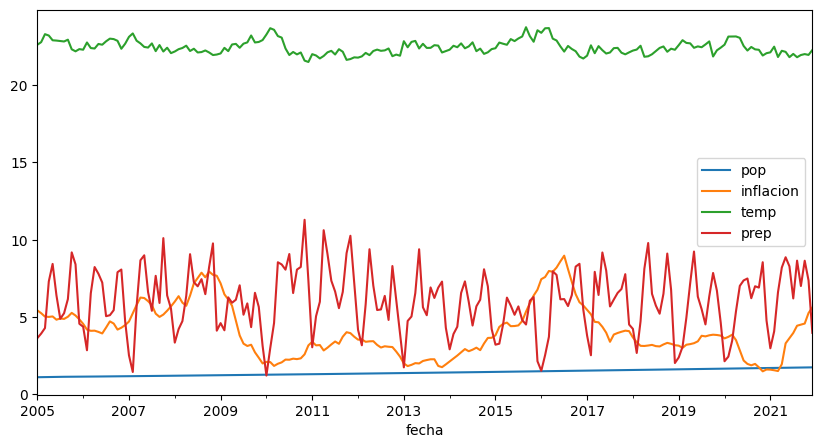

In [15]:
# Preparación del dato
# Paso 3: cambiar la frecuencia de los datos a mensual ('MS')
datos = df.asfreq('MS')

# Paso 4: graficar las variables de interés
fig, ax = plt.subplots(figsize=(10, 5))
datos['pop'].plot(ax=ax, label='pop')
datos['inflacion'].plot(ax=ax, label='inflacion')
datos['temp'].plot(ax=ax, label='temp')
datos['prep'].plot(ax=ax, label='prep')
ax.legend();

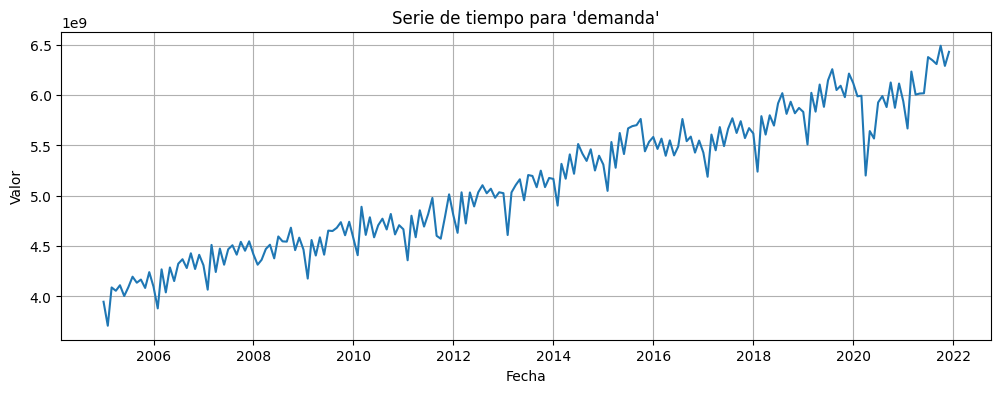

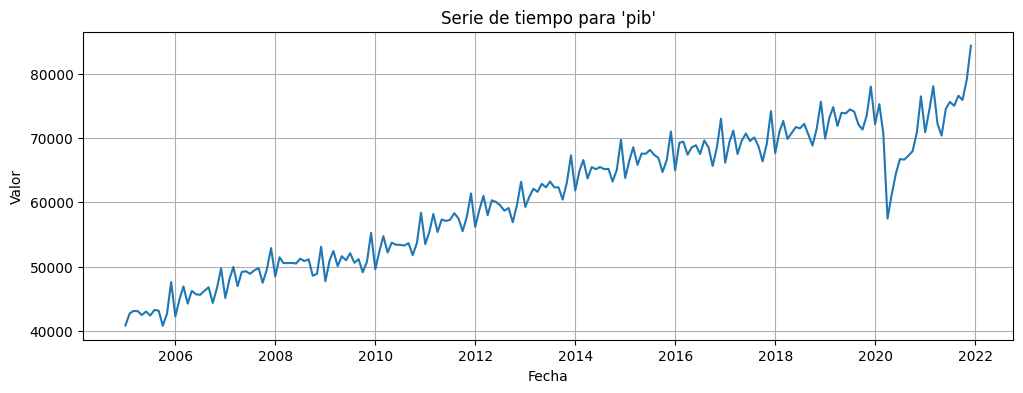

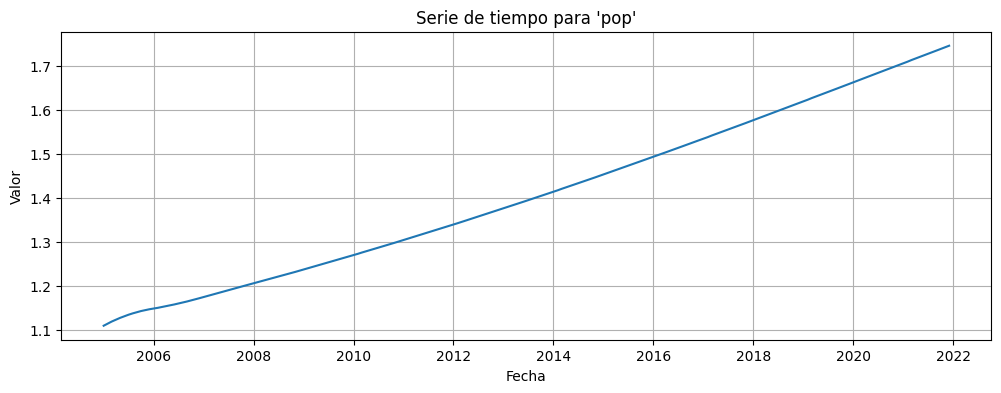

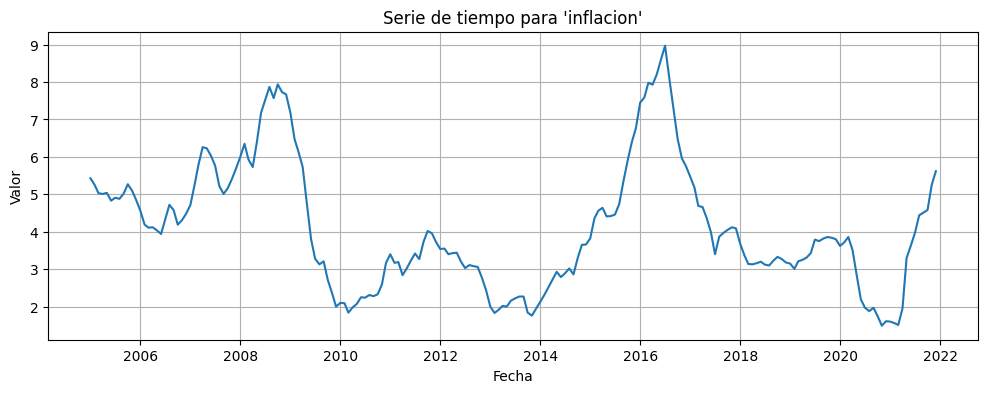

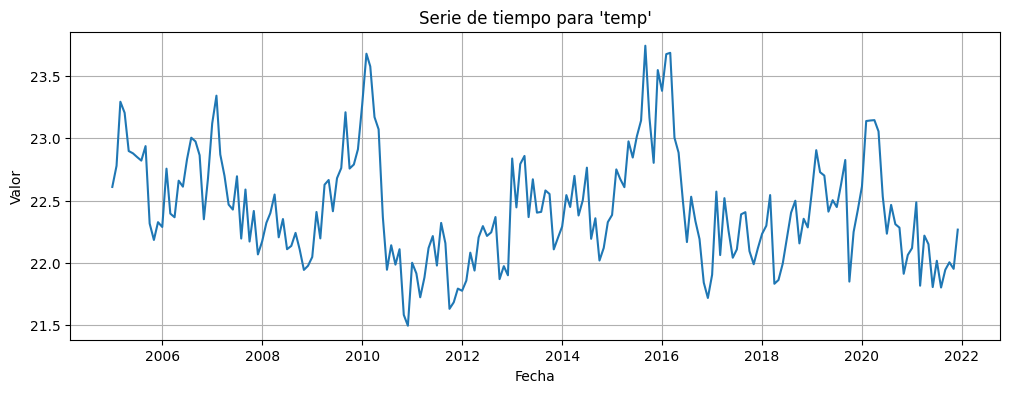

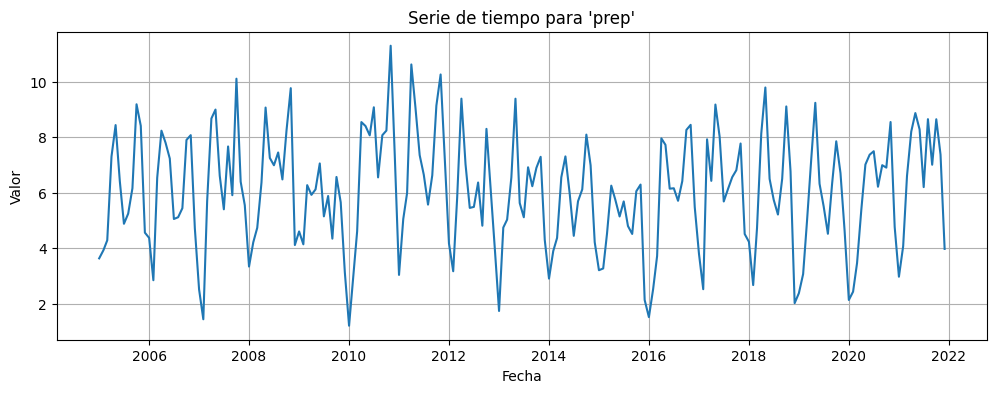

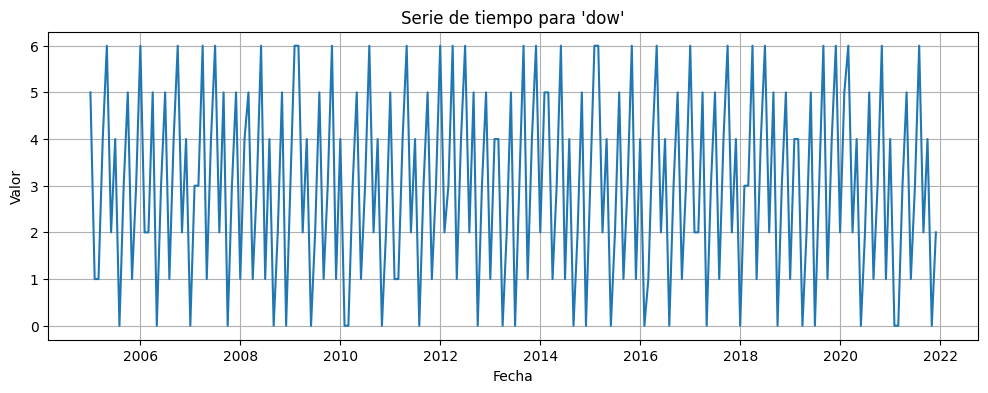

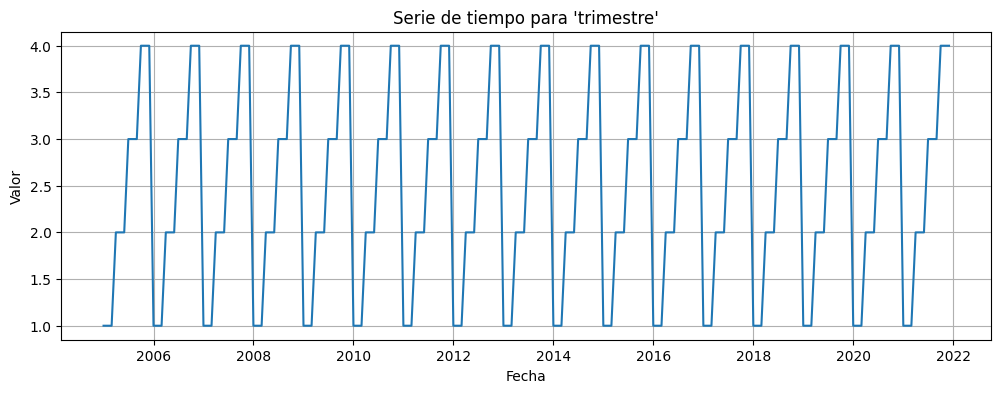

In [16]:
tool.modeling.plot_data(df)

### Diferenciación

In [9]:
# Especificar las columnas a las que se les aplicará la diferenciación
columns_to_difference = ['demanda', 'pib']

# Aplicar la diferenciación al DataFrame
df_diff = tool.modeling.apply_differencing(df, columns_to_difference)

### Transformaciones para modelar variables estacionarias

In [10]:
df_boxcox=tool.modeling.boxcox_transform(df)

Columna demanda: lambda=0.44. Se recomienda la transformación de raíz cuadrada.
    El p-valor para la columna demanda es 0.0000, por lo que se sugiere verificar la distribución transformada.
Columna pib: lambda=1.27. Transformada con éxito.
    El p-valor para la columna pib es 0.0000, por lo que se sugiere verificar la distribución transformada.
Columna pop: lambda=-0.08. Se recomienda la transformación logarítmica.
    El p-valor para la columna pop es 0.0000, por lo que se sugiere verificar la distribución transformada.
Columna inflacion: lambda=0.12. Transformada con éxito.
    El p-valor para la columna inflacion es 0.0729, la distribución transformada parece ser normal.
Columna temp: lambda=-10.60. Se recomienda la transformación logarítmica.
    El p-valor para la columna temp es nan, la distribución transformada parece ser normal.
Columna prep: lambda=1.02. No se necesita transformación.
    El p-valor para la columna prep es 0.3627, la distribución transformada parece ser nor

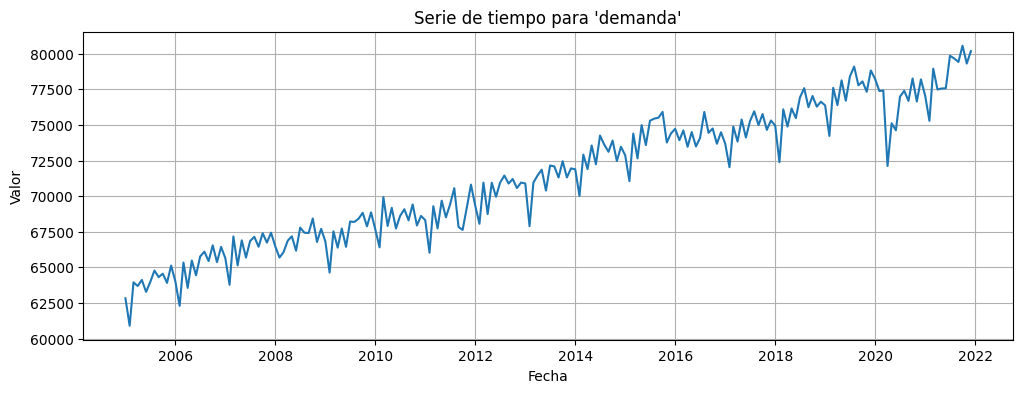

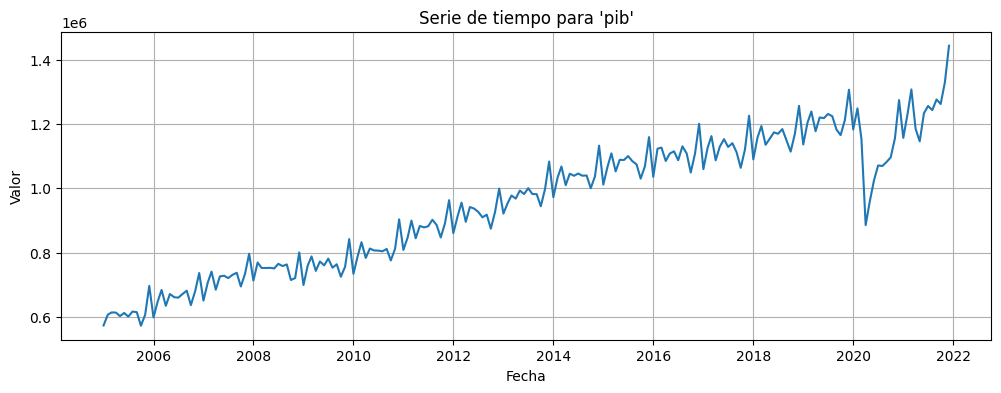

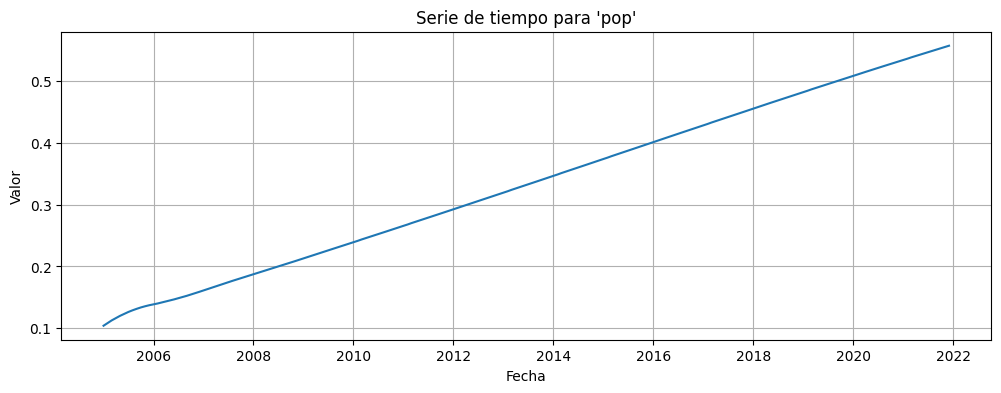

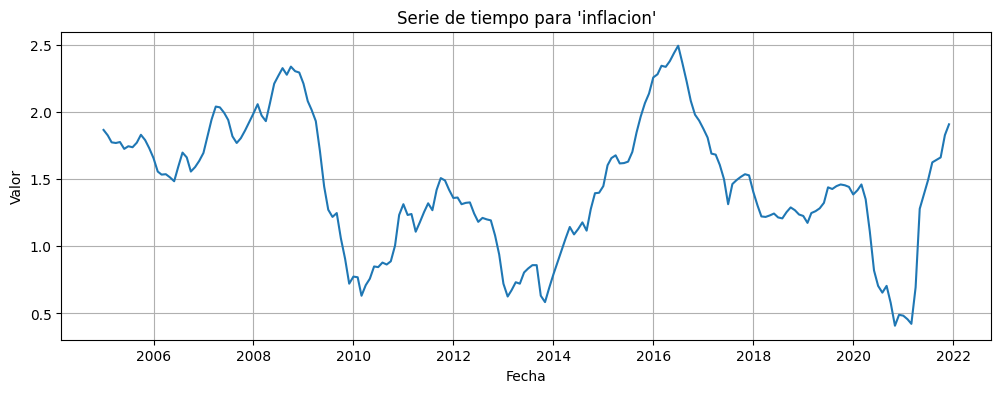

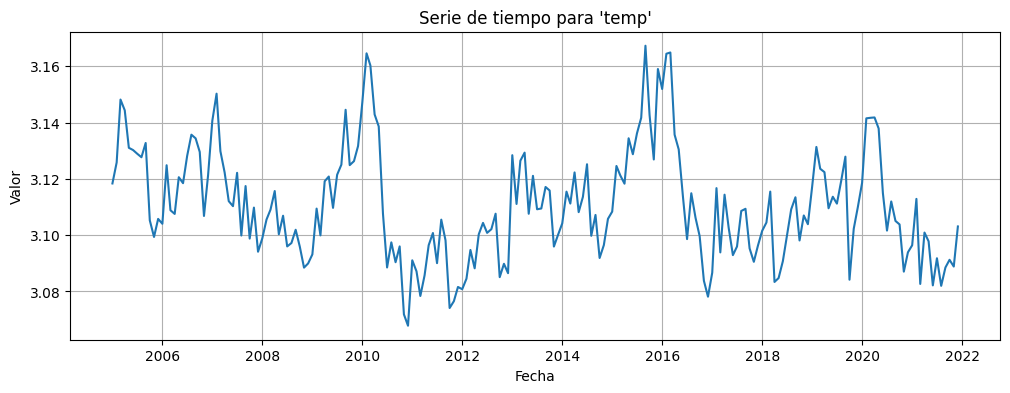

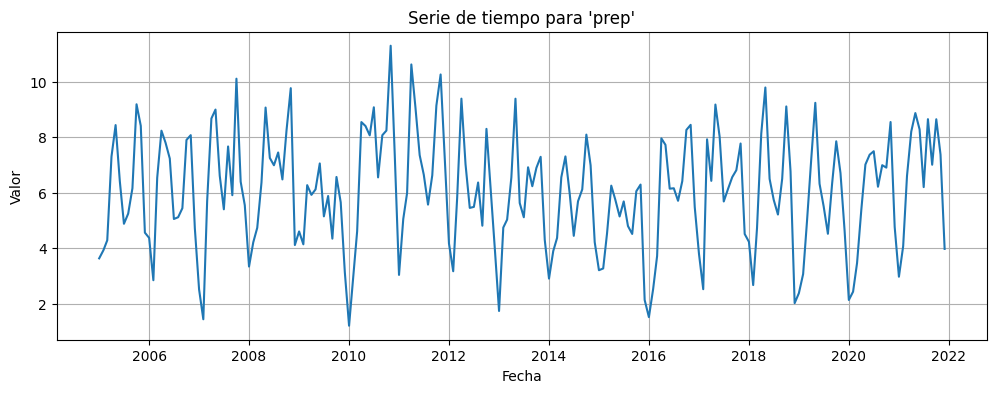

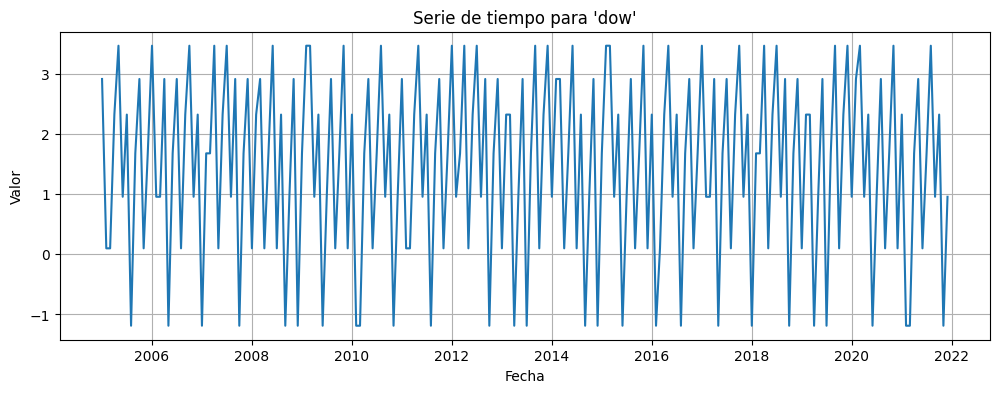

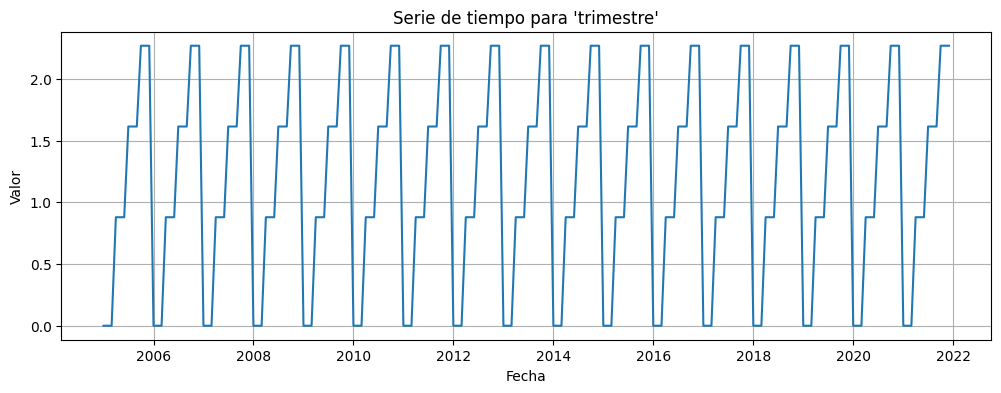

In [11]:
tool.modeling.plot_data(df_boxcox)

### Transformación Yeo

In [12]:
df_yeo=tool.modeling.yeo_johnson_test(df)

Columna demanda: lambda=0.44. Se recomienda la transformación logarítmica.
Columna pib: lambda=1.27. Transformada con éxito.
Columna pop: lambda=-0.67. Se recomienda la transformación logarítmica.
Columna inflacion: lambda=-0.10. Se recomienda la transformación logarítmica.
Columna temp: lambda=-10.11. Se recomienda la transformación logarítmica.
Columna prep: lambda=1.05. No se necesita transformación.
Columna dow: lambda=0.71. Transformada con éxito.
Columna trimestre: lambda=0.67. Transformada con éxito.


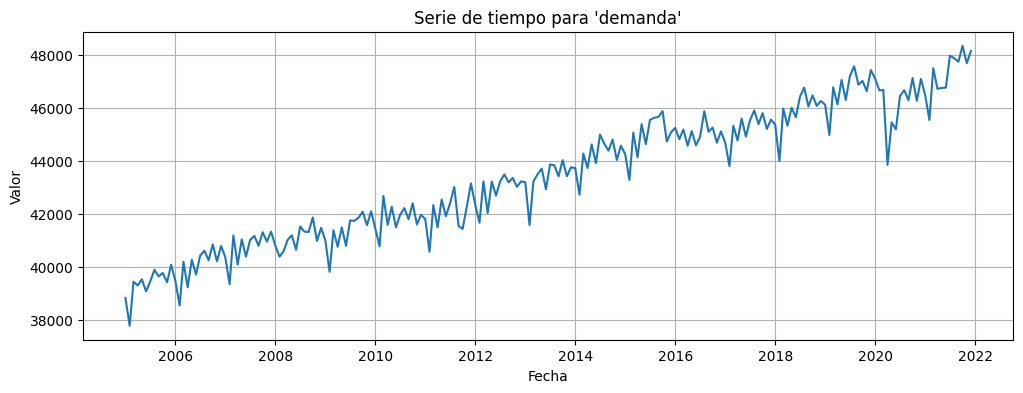

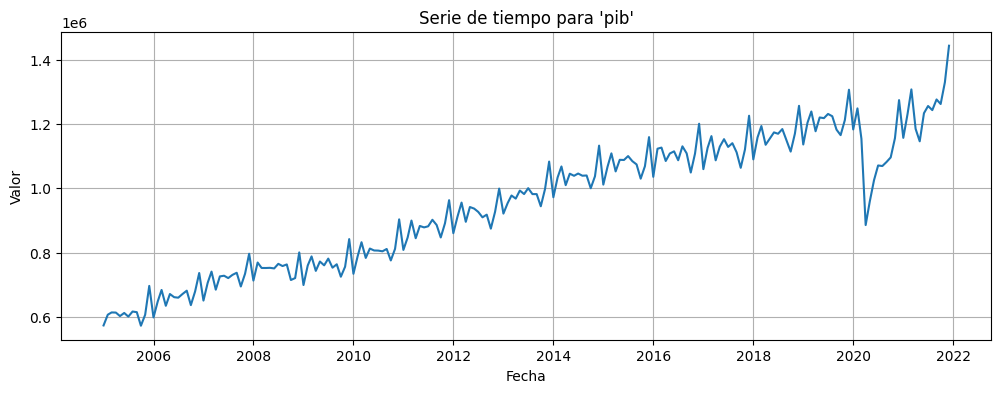

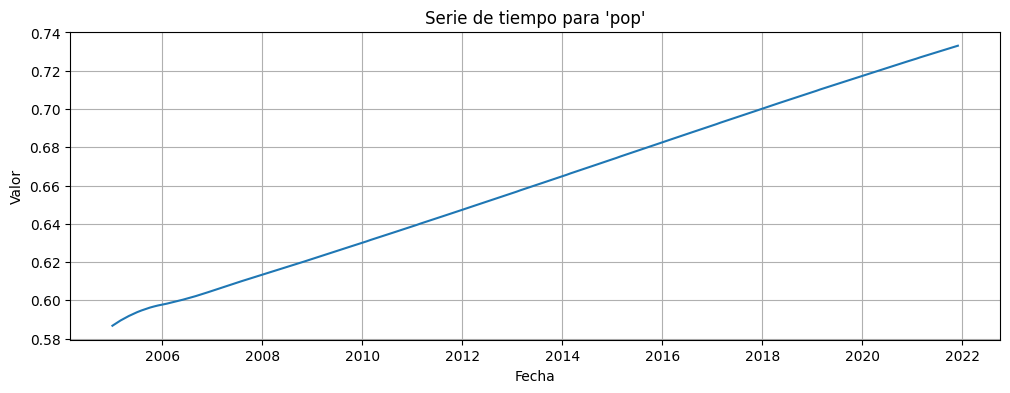

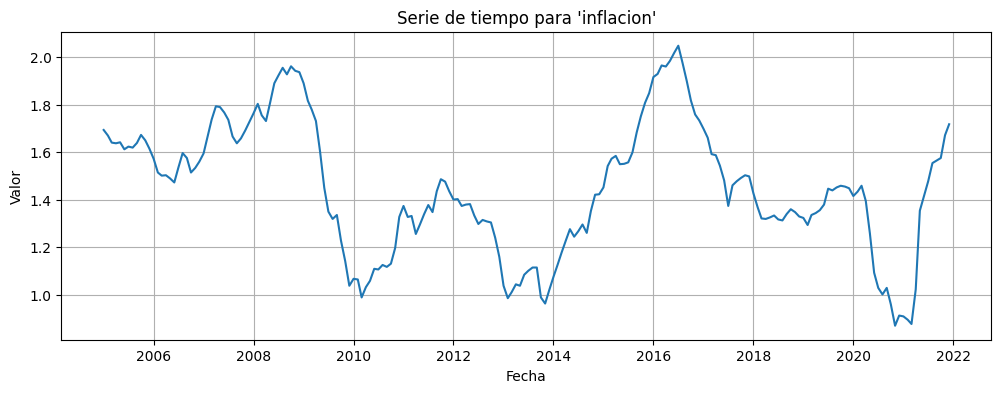

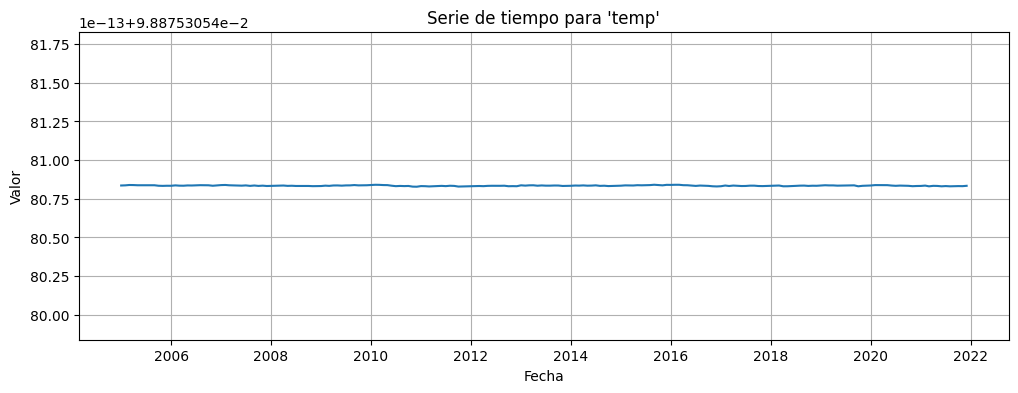

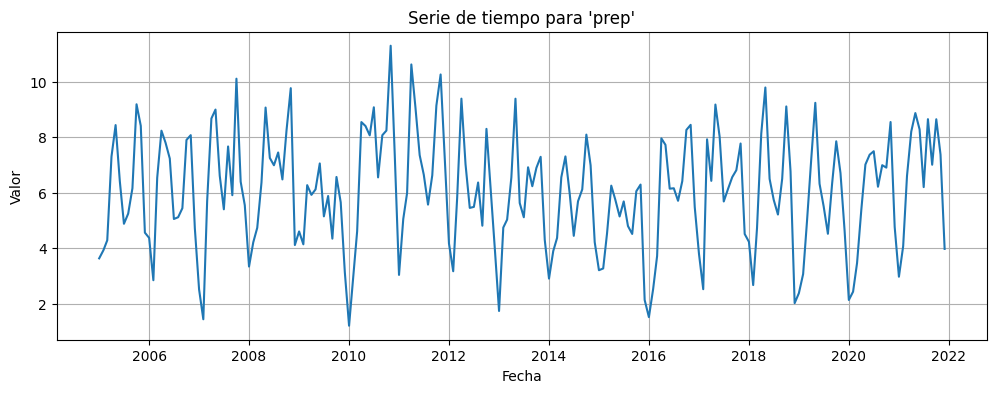

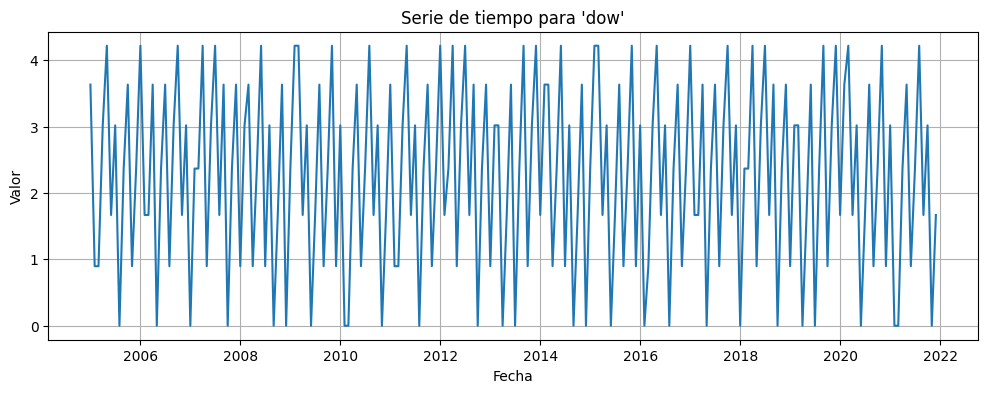

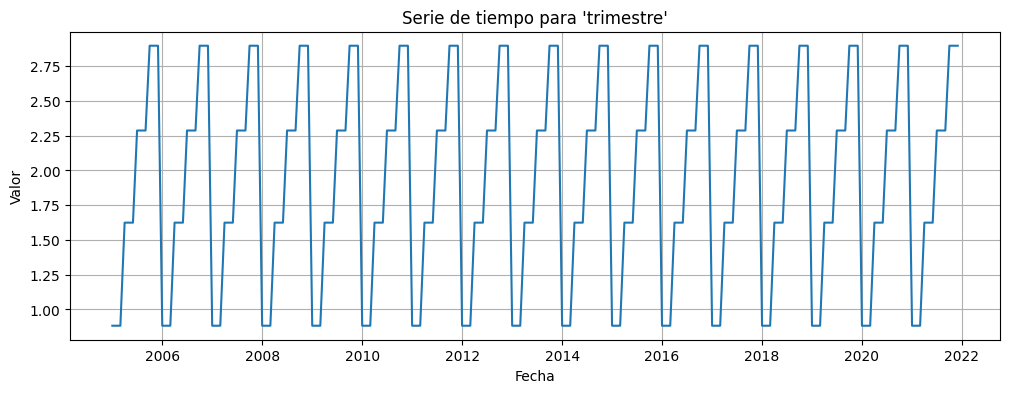

In [13]:
tool.modeling.plot_data(df_yeo)

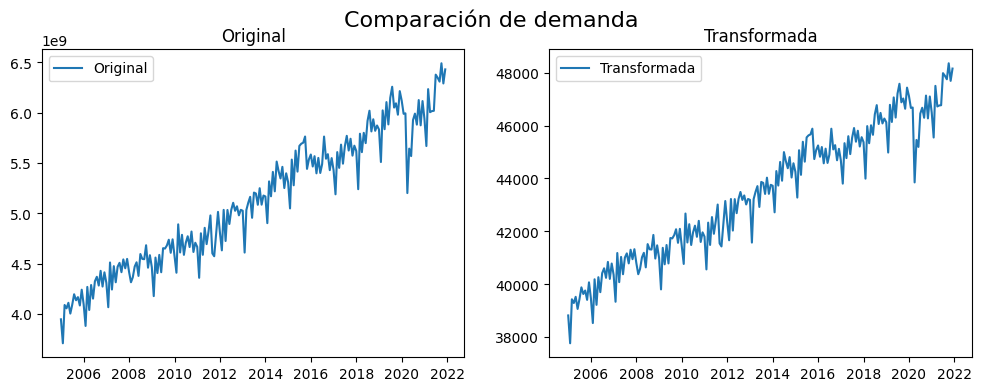

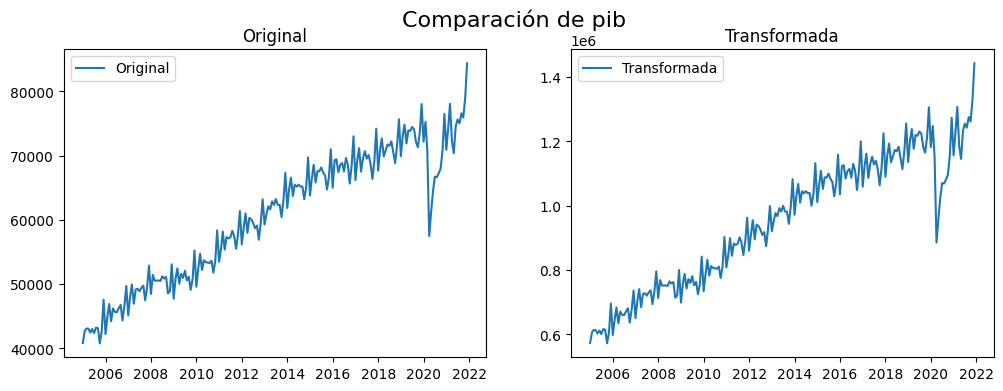

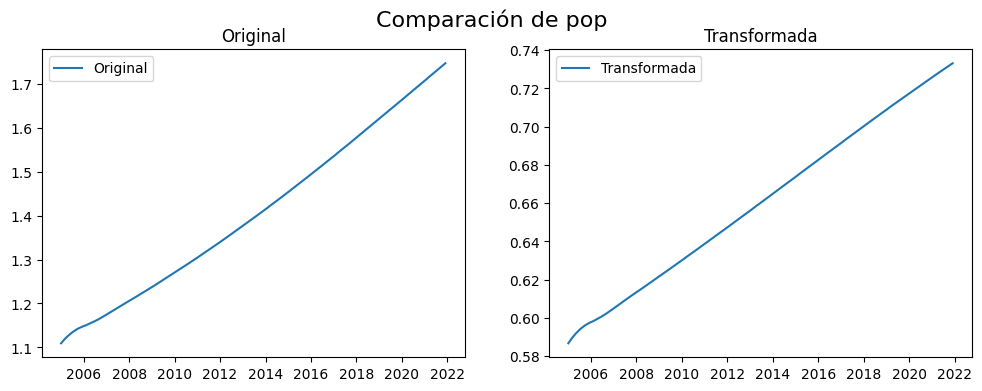

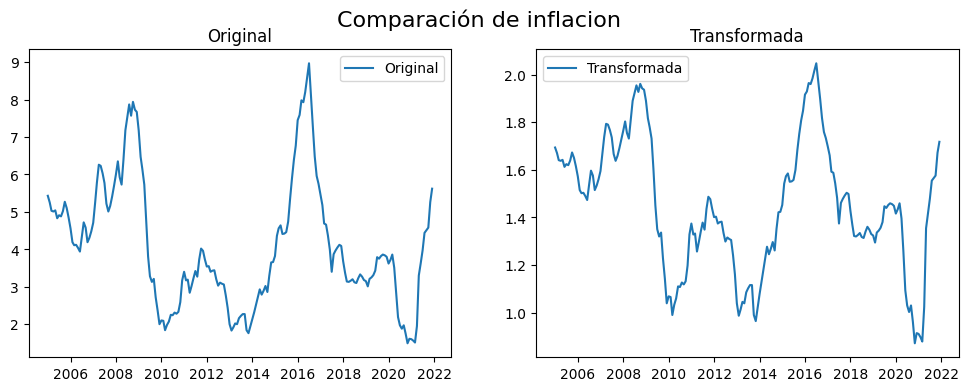

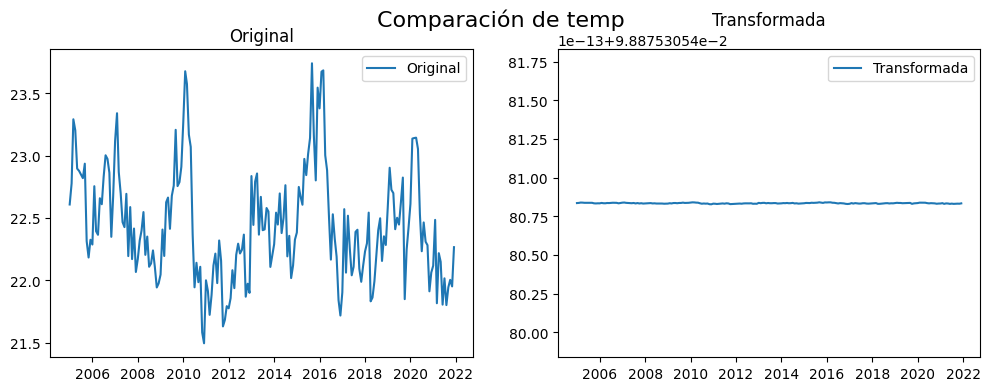

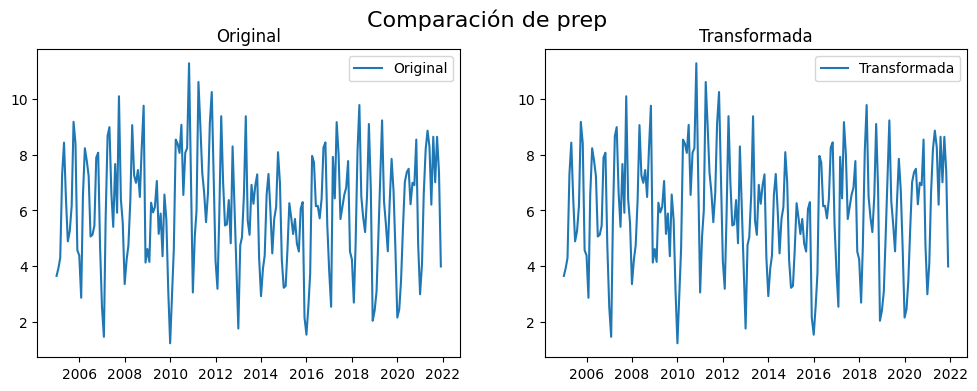

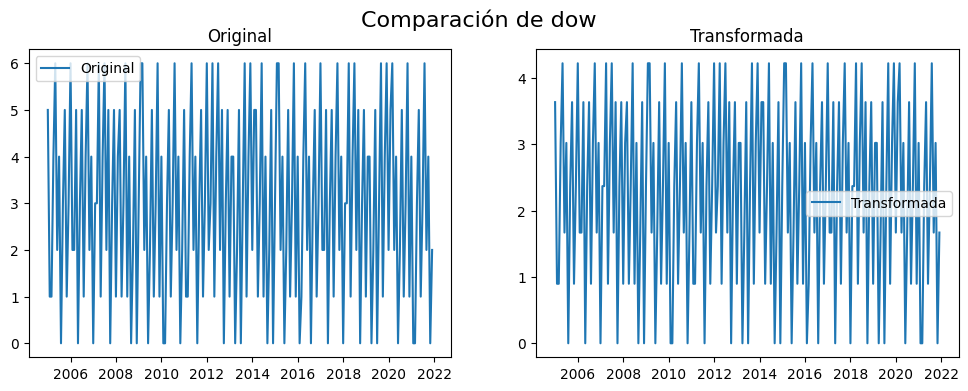

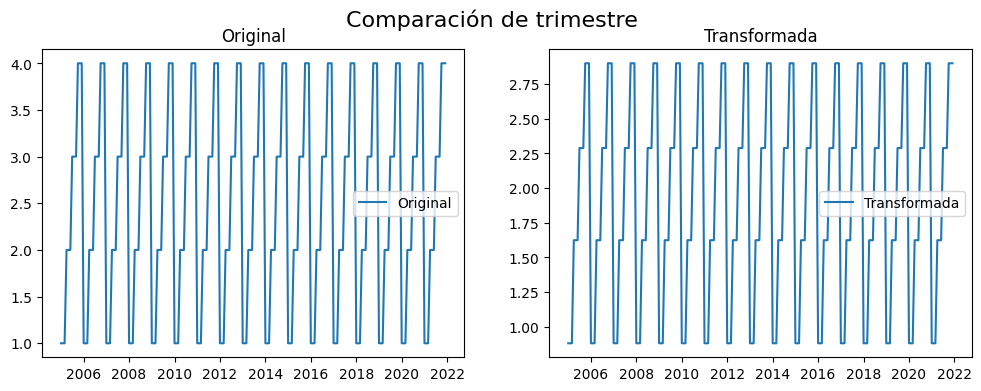

In [14]:
tool.modeling.plot_comparison(df, df_yeo)

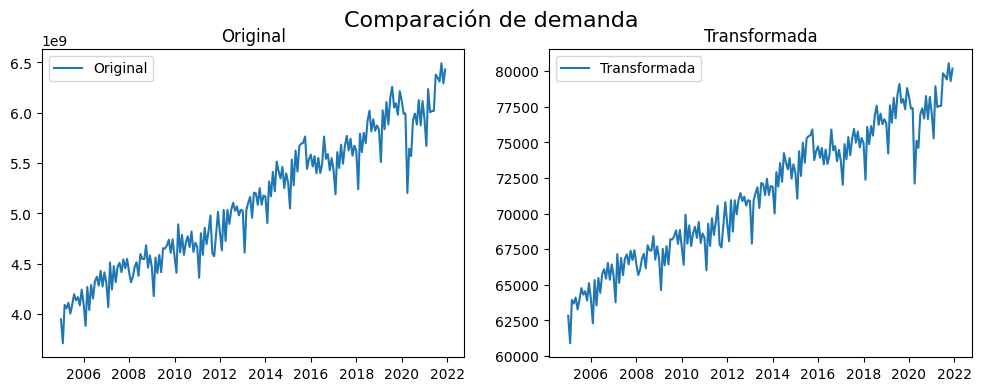

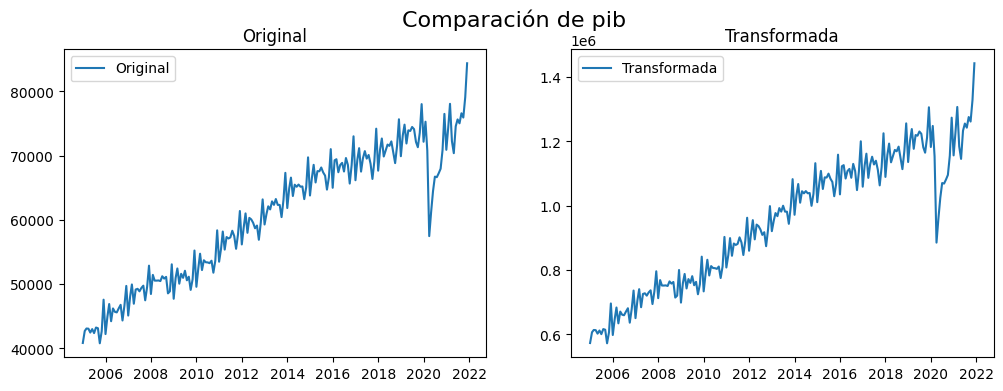

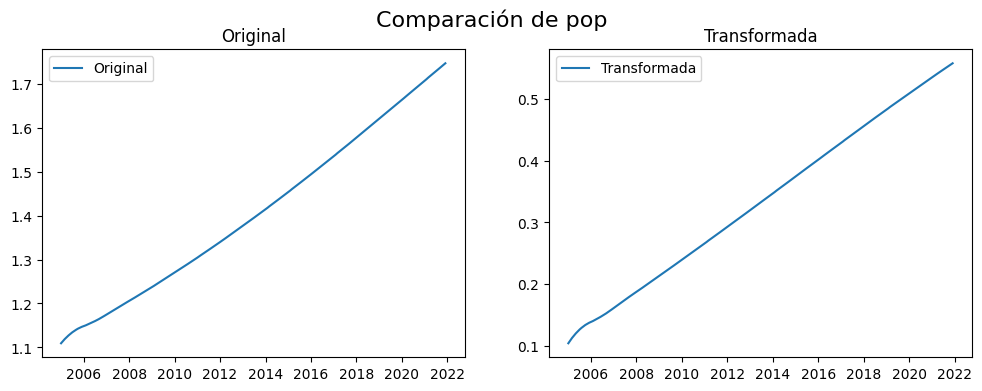

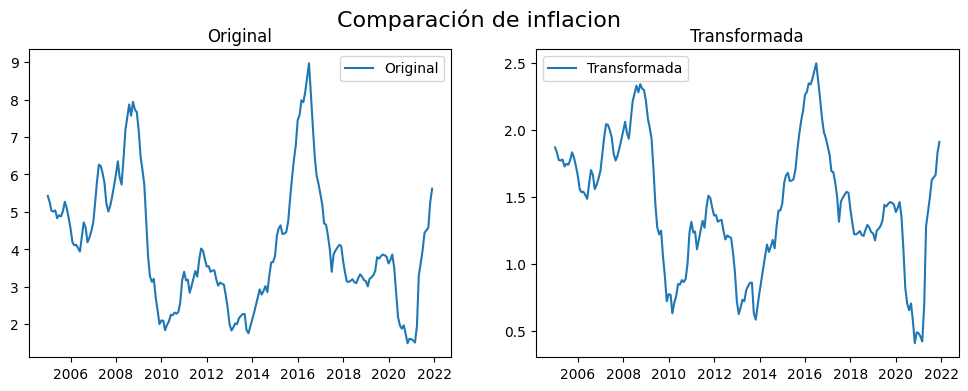

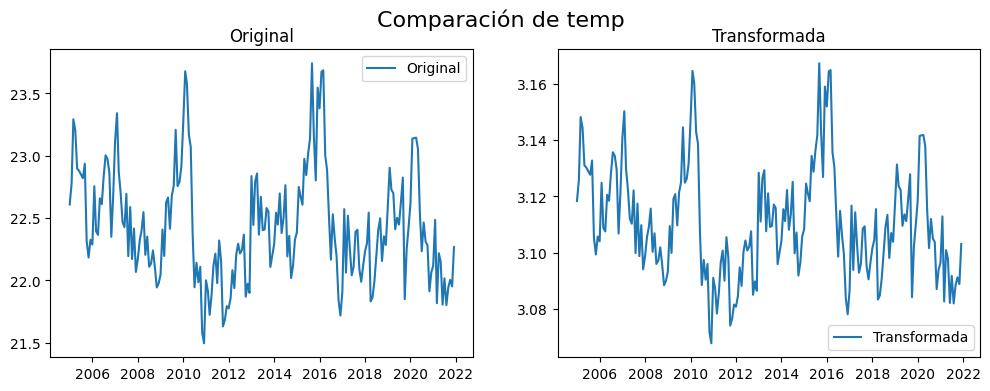

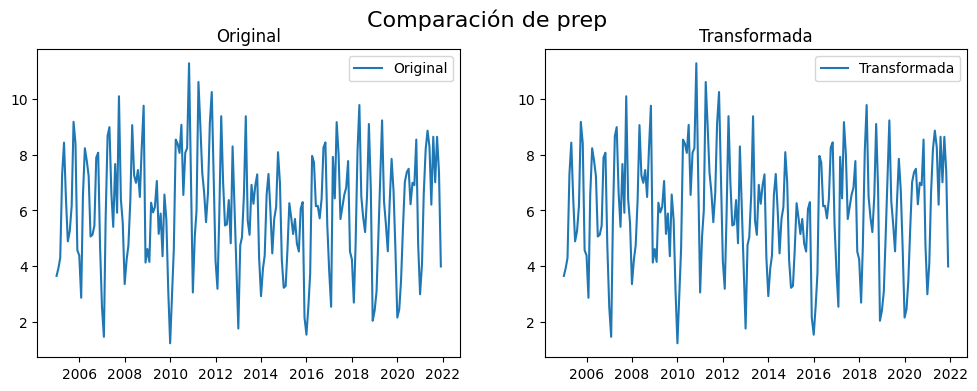

In [33]:
tool.modeling.plot_comparison(df, df_boxcox)

### MODELING

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     805.8
Date:                Sun, 21 May 2023   Prob (F-statistic):          1.73e-129
Time:                        19:10:10   Log-Likelihood:                -4119.7
No. Observations:                 204   AIC:                             8251.
Df Residuals:                     198   BIC:                             8271.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.715e+09   6.24e+08     -2.750      0.0

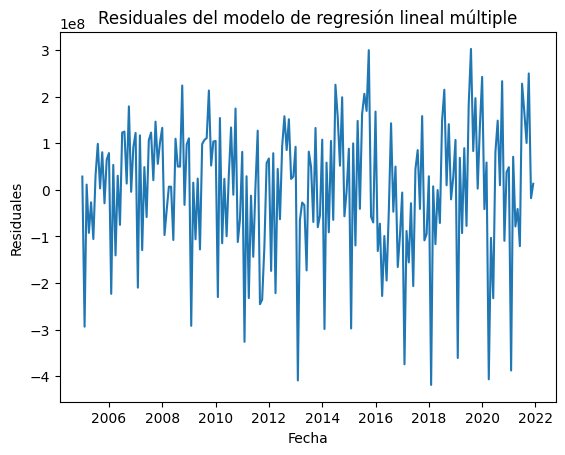

In [17]:
# Leer los datos de la demanda de energía en Colombia

# Realizar el modelo de regresión lineal múltiple con las covariables
model = sm.OLS(df['demanda'], sm.add_constant(df[['pib', 'pop', 'inflacion', 'temp', 'prep']]))

# Ajustar el modelo a los datos y obtener los resultados
results = model.fit()

# Imprimir los resultados de la regresión
print(results.summary())

# Graficar los residuales del modelo
plt.plot(results.resid)
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.title('Residuales del modelo de regresión lineal múltiple')
plt.show()

# R-cuadrado de 0.953, lo que significa que el 95.3% de la variación en la variable dependiente se explica por las variables independientes incluidas en el modelo.
# El F-estadístico (805.8) y el valor p asociado (1.73e-129) indican que el modelo en su conjunto es estadísticamente significativo, es decir, que hay evidencia suficiente para rechazar la hipótesis nula de que todos los coeficientes de las variables independientes son iguales a cero.
#Sin embargo, el coeficiente estimado para "inflacion" no es estadísticamente significativo a un nivel de confianza del 95%.

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1209.
Date:                Sun, 21 May 2023   Prob (F-statistic):          8.56e-113
Time:                        19:09:33   Log-Likelihood:                -1622.2
No. Observations:                 204   AIC:                             3250.
Df Residuals:                     201   BIC:                             3260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.162e+04    285.670    110.691      0.0

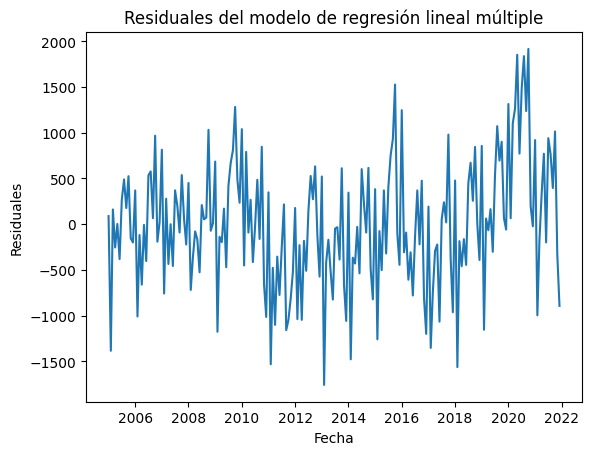

In [16]:
#Eliminando la variable pop y prep, inflación

# Realizar el modelo de regresión lineal múltiple con las covariables
model = sm.OLS(df_yeo['demanda'], sm.add_constant(df_yeo[['pib', 'prep']]))

# Ajustar el modelo a los datos y obtener los resultados
results = model.fit()

# Imprimir los resultados de la regresión
print(results.summary())

# Graficar los residuales del modelo
plt.plot(results.resid)
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.title('Residuales del modelo de regresión lineal múltiple')
plt.show()

#La eliminación de la variable "población" del modelo redujo el valor del R-cuadrado ajustado ligeramente de 0.924 a 0.922. Además, el coeficiente de la variable "inflación" sigue siendo estadísticamente insignificante con un valor p de 0.381, lo que sugiere que esta variable no está contribuyendo significativamente a la predicción de la variable "demanda". La eliminación de la variable "población" también redujo el valor de la estadística F del modelo, que mide la significancia global del modelo, pero sigue siendo muy significativo con un valor de p muy bajo. La estadística Omnibus y el valor Durbin-Watson se encuentran dentro de los valores aceptables, lo que indica que no hay problemas importantes con la normalidad y la autocorrelación de los errores del modelo. Sin embargo, el valor de la condición del número sigue siendo alto, lo que sugiere la posible presencia de multicolinealidad o problemas numéricos. Por lo tanto, se recomienda una exploración más detallada de la multicolinealidad y/o la exploración de otros modelos que puedan mejorar aún más la precisión de la predicción.


El MSE (Mean Squared Error) es una medida de la calidad de ajuste del modelo. Representa el promedio de los errores al cuadrado entre los valores observados y los valores predichos por el modelo. Cuanto menor sea el valor del MSE, mejor será el ajuste del modelo.

El valor del MSE que has obtenido es muy grande, lo que indica que el modelo no ajusta bien a los datos. Es posible que la inclusión de todas las covariables no sea adecuada o que la forma funcional del modelo no sea la más adecuada para estos datos.

El MAE (Mean Absolute Error) también es una medida de la calidad del ajuste del modelo. Representa el promedio de las diferencias absolutas entre los valores observados y los valores predichos por el modelo. Cuanto menor sea el valor del MAE, mejor será el ajuste del modelo.

El valor del MAE que has obtenido es bastante grande, lo que indica que el modelo no ajusta bien a los datos. Es posible que la inclusión de todas las covariables no sea adecuada o que la forma funcional del modelo no sea la más adecuada para estos datos.

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     962.8
Date:                Sun, 21 May 2023   Prob (F-statistic):          5.92e-129
Time:                        19:10:19   Log-Likelihood:                -1576.7
No. Observations:                 204   AIC:                             3163.
Df Residuals:                     199   BIC:                             3180.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.502e+04   1624.265      9.248      0.0

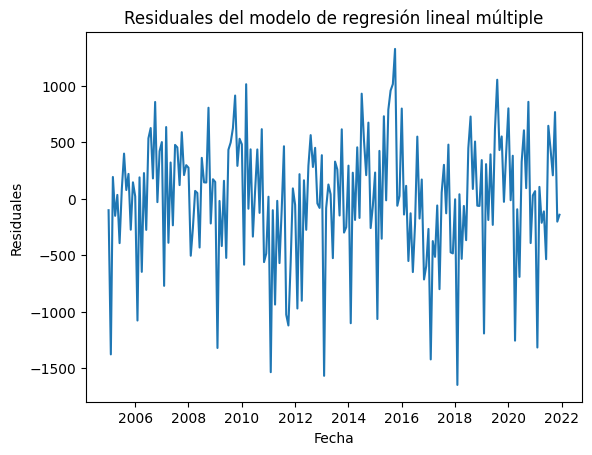

In [18]:
# Leer los datos de la demanda de energía en Colombia

# Realizar el modelo de regresión lineal múltiple con las covariables
model = sm.OLS(df_yeo['demanda'], sm.add_constant(df_yeo[['pib', 'pop', 'inflacion', 'temp', 'prep']]))

# Ajustar el modelo a los datos y obtener los resultados
results = model.fit()

# Imprimir los resultados de la regresión
print(results.summary())

# Graficar los residuales del modelo
plt.plot(results.resid)
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.title('Residuales del modelo de regresión lineal múltiple')
plt.show()

### Separación datos train-test

In [19]:
# Separación datos train-test
# ==============================================================================
steps = 36
train = df_yeo[:-steps]
test  = df_yeo[-steps:]

print(f"Fechas train : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Fechas test  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Fechas train : 2005-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=168)
Fechas test  : 2019-01-01 00:00:00 --- 2021-12-01 00:00:00  (n=36)


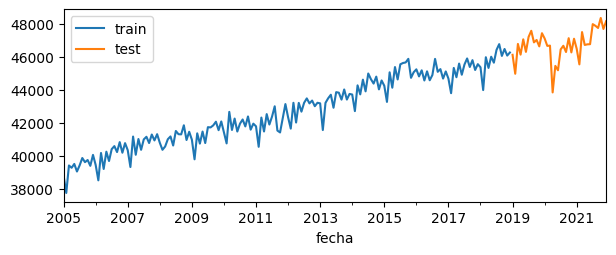

In [20]:
fig, ax = plt.subplots(figsize=(7, 2.5))
train['demanda'].plot(ax=ax, label='train')
test['demanda'].plot(ax=ax, label='test')
ax.legend();

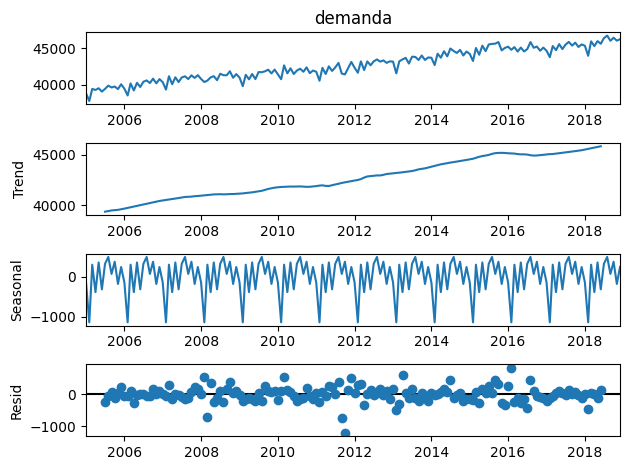

In [25]:
# perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(train['demanda'],period =12) 
figure = decomposition.plot()
plt.show()

#### SimpleExpSmoothing

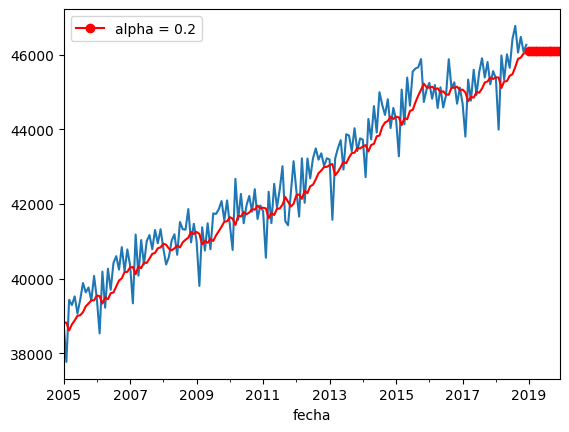

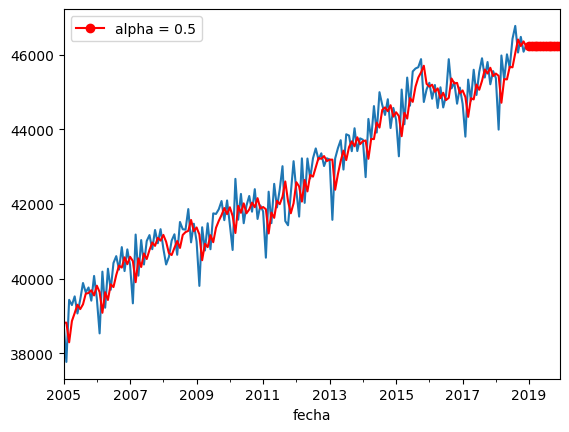

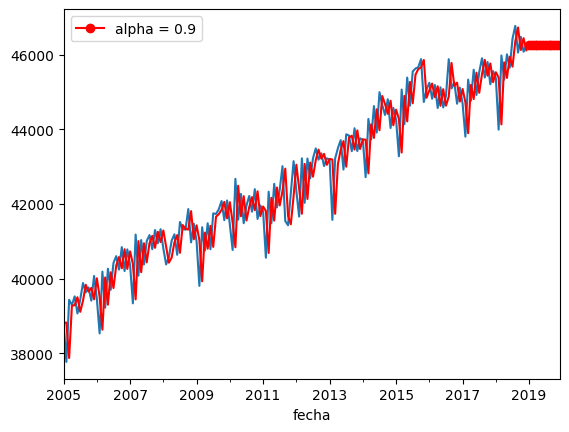

In [23]:
for alpha_sm in [0.2 , 0.5, 0.9]:

    train['demanda'].plot.line()
    fit1 = SimpleExpSmoothing(train['demanda']).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

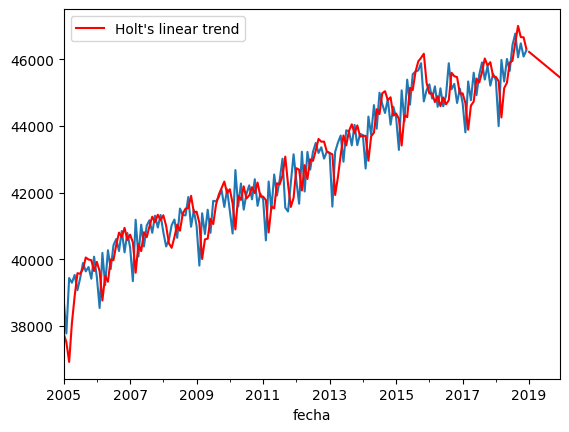

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
train['demanda'].plot.line()

fit1 = Holt(train['demanda']).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)

plt.show()

In [26]:
#el orden correcto es aplicar la diferenciación primero para eliminar la tendencia y luego aplicar la transformación logarítmica a la serie diferenciada para estabilizar la varianza. 
fit1 = ExponentialSmoothing(train['demanda'].values, seasonal_periods=12, trend='mul', seasonal='mul', use_boxcox=True)
fit1 = fit1.fit()
fit1.params_formatted

name  param  optimized
smoothing_level     alpha    0.4       True
smoothing_trend      beta    0.0       True
smoothing_seasonal  gamma    0.0       True
initial_level         l.0 7331.4       True
initial_trend         b.0    1.0       True
initial_seasons.0     s.0    1.0       True
initial_seasons.1     s.1    1.0       True
initial_seasons.2     s.2    1.0       True
initial_seasons.3     s.3    1.0       True
initial_seasons.4     s.4    1.0       True
initial_seasons.5     s.5    1.0       True
initial_seasons.6     s.6    1.0       True
initial_seasons.7     s.7    1.0       True
initial_seasons.8     s.8    1.0       True
initial_seasons.9     s.9    1.0       True
initial_seasons.10   s.10    1.0       True
initial_seasons.11   s.11    1.0       True

<Axes: xlabel='fecha'>

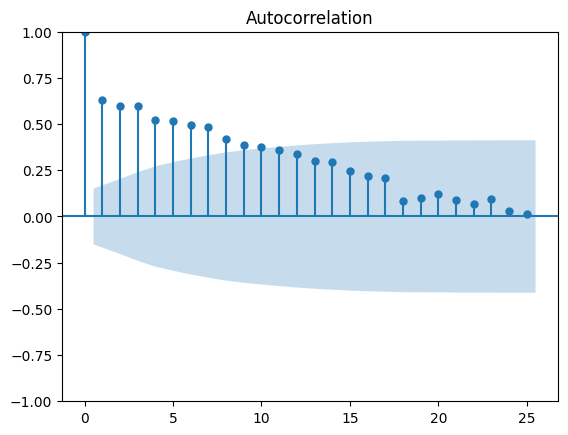

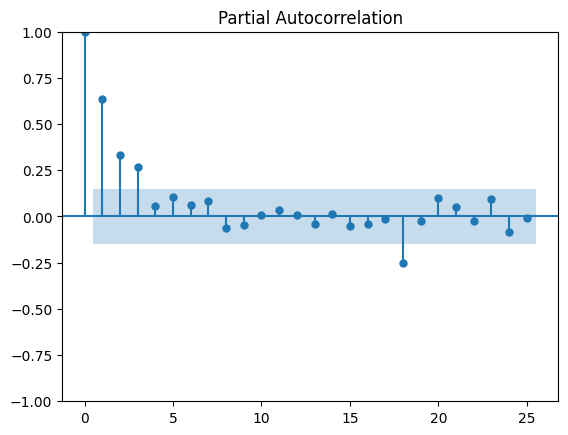

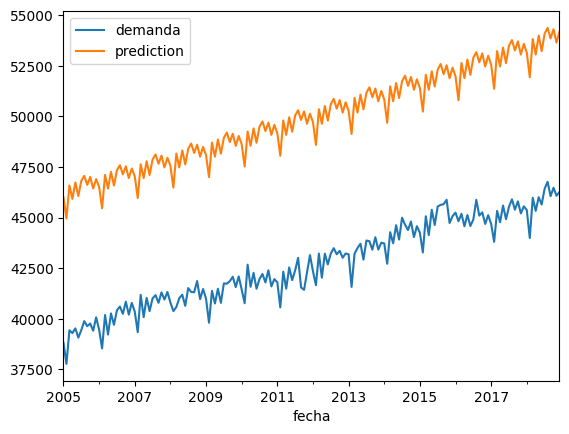

In [27]:
# What do the residuals look like?
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
prediction = fit1.forecast(len(train['demanda'])).copy()

xresiduals = train['demanda'] - prediction
plot_acf(xresiduals, lags = 25)
print()

plot_pacf(xresiduals, lags = 25)
print()


train['prediction'] = prediction
train[['demanda','prediction']].plot()

In [31]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
import numpy as np

# Parámetros a probar
seasonal_periods = [12, 24]
trend_options = ['add', 'mul']
seasonal_options = ['add', 'mul']

# Métricas de error
error_metrics = ['mse', 'mae', 'rmse']  # Agrega las métricas que desees

# Mejores resultados iniciales
best_error = np.inf
best_model = None
best_params = None
errors = {}  # Diccionario para almacenar los errores

# Probar diferentes combinaciones de parámetros y métricas de error
for period in seasonal_periods:
    for trend in trend_options:
        for seasonal in seasonal_options:
            errors[(period, trend, seasonal)] = {}  # Diccionario para almacenar los errores de cada métrica
            for metric in error_metrics:
                model = ExponentialSmoothing(
                    train['demanda'],
                    seasonal_periods=period,
                    trend=trend,
                    seasonal=seasonal,
                    use_boxcox=False
                )
                fitted_model = model.fit()

                # Calcular el error correspondiente a la métrica seleccionada
                if metric == 'mse':
                    error = np.mean((fitted_model.fittedvalues - train['demanda']) ** 2)
                elif metric == 'mae':
                    error = np.mean(np.abs(fitted_model.fittedvalues - train['demanda']))
                elif metric == 'rmse':
                    error = np.sqrt(np.mean((fitted_model.fittedvalues - train['demanda']) ** 2))
                else:
                    raise ValueError("Métrica de error no válida")

                errors[(period, trend, seasonal)][metric] = error

                # Actualizar el mejor modelo si se encuentra una mejor combinación de parámetros y métrica de error
                if error < best_error:
                    best_error = error
                    best_model = fitted_model
                    best_params = {
                        'seasonal_periods': period,
                        'trend': trend,
                        'seasonal': seasonal
                    }

# Imprimir los errores para todas las combinaciones de parámetros
for params, metric_errors in errors.items():
    print("Parámetros:", params)
    for metric, error in metric_errors.items():
        print(metric, ":", error)
    print()

# Imprimir los parámetros y el error del mejor modelo
print("Mejor modelo:")
print(best_model.model)
print("Parámetros escogidos:")
print(best_params)
print("Error:", best_error)

Parámetros: (12, 'add', 'add')
mse : 86945.78093929529
mae : 221.8696528379248
rmse : 294.8656998351882

Parámetros: (12, 'add', 'mul')
mse : 93060.94855449087
mae : 231.6073308030663
rmse : 305.05892636422044

Parámetros: (12, 'mul', 'add')
mse : 92703.02690437784
mae : 230.96784437639118
rmse : 304.47171774136564

Parámetros: (12, 'mul', 'mul')
mse : 93762.77783995953
mae : 232.44496452854113
rmse : 306.2070832622255

Parámetros: (24, 'add', 'add')
mse : 82097.7001551496
mae : 220.14255385082924
rmse : 286.5269623528467

Parámetros: (24, 'add', 'mul')
mse : 91695.47266853583
mae : 222.43469967261436
rmse : 302.812603219443

Parámetros: (24, 'mul', 'add')
mse : 85957.37771168482
mae : 226.4772075720916
rmse : 293.18488656764833

Parámetros: (24, 'mul', 'mul')
mse : 87266.00122664978
mae : 227.56696813351806
rmse : 295.4081942442521

Mejor modelo:
Parámetros escogidos:
{'seasonal_periods': 24, 'trend': 'add', 'seasonal': 'add'}
Error: 220.14255385082924


In [33]:
# Extraer la columna 'demanda' del DataFrame test
test_data = test['demanda']

# Realizar predicciones en el conjunto de prueba (test_data)
predictions = best_model.predict(start=test_data.index[0], end=test_data.index[-1])

# Imprimir las predicciones
print("Predicciones en el conjunto de prueba:")
print(predictions)


Predicciones en el conjunto de prueba:
2019-01-01   46010.9
2019-02-01   44821.3
2019-03-01   46511.5
2019-04-01   45942.0
2019-05-01   46681.5
2019-06-01   45998.6
2019-07-01   46716.8
2019-08-01   46922.1
2019-09-01   46455.1
2019-10-01   46750.6
2019-11-01   46467.4
2019-12-01   46986.9
2020-01-01   46550.8
2020-02-01   45807.3
2020-03-01   47135.4
2020-04-01   46458.3
2020-05-01   47213.3
2020-06-01   46622.5
2020-07-01   47288.5
2020-08-01   47463.3
2020-09-01   47112.0
2020-10-01   47562.0
2020-11-01   46920.3
2020-12-01   47327.8
2021-01-01   47001.0
2021-02-01   45811.3
2021-03-01   47501.5
2021-04-01   46932.1
2021-05-01   47671.6
2021-06-01   46988.7
2021-07-01   47706.9
2021-08-01   47912.1
2021-09-01   47445.1
2021-10-01   47740.7
2021-11-01   47457.5
2021-12-01   47977.0
Freq: MS, dtype: float64


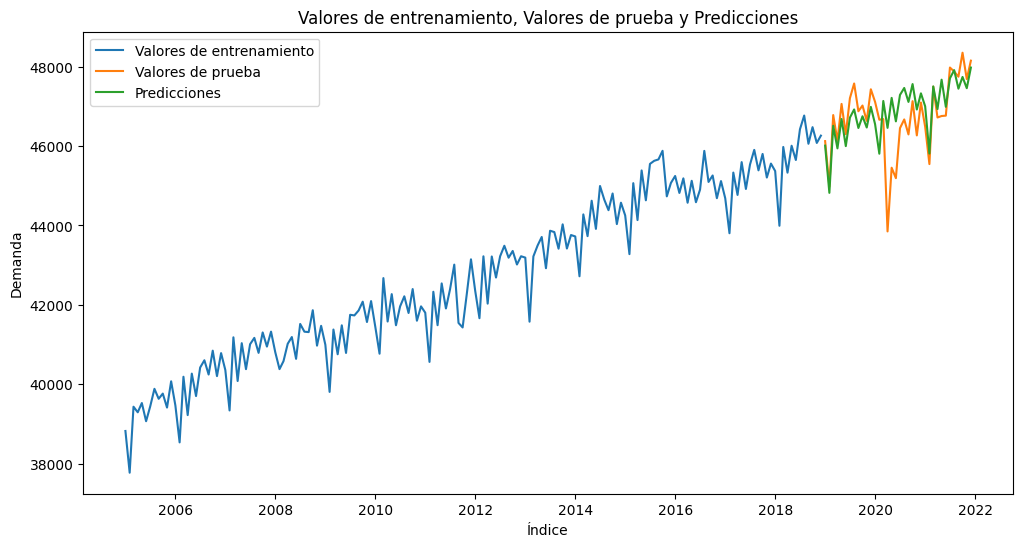

In [34]:
import matplotlib.pyplot as plt

# Extraer la columna 'demanda' del DataFrame test
test_data = test['demanda']

# Realizar predicciones en el conjunto de prueba (test_data)
predictions = best_model.predict(start=test_data.index[0], end=test_data.index[-1])

# Graficar los valores originales y las predicciones
plt.figure(figsize=(12, 6))
plt.plot(train['demanda'], label='Valores de entrenamiento')
plt.plot(test_data, label='Valores de prueba')
plt.plot(predictions, label='Predicciones')
plt.xlabel('Índice')
plt.ylabel('Demanda')
plt.title('Valores de entrenamiento, Valores de prueba y Predicciones')
plt.legend()
plt.show()


In [39]:
train.columns

Index(['demanda', 'pib', 'pop', 'inflacion', 'temp', 'prep', 'dow', 'trimestre', 'prediction'], dtype='object')

In [41]:
from statsmodels.tsa.api import ExponentialSmoothing
import numpy as np

# Parámetros a probar
seasonal_periods = [12, 24]
trend_options = ['add', 'mul', 'additive', 'multiplicative']
seasonal_options = ['add', 'mul', 'additive', 'multiplicative']

# Métricas de error
error_metrics = ['mse', 'mae', 'rmse']  # Agrega las métricas que desees

# Mejores resultados iniciales
best_error = np.inf
best_model = None
best_params = None
errors = {}  # Diccionario para almacenar los errores

# Probar diferentes combinaciones de parámetros y métricas de error
for period in seasonal_periods:
    for trend in trend_options:
        for seasonal in seasonal_options:
            errors[(period, trend, seasonal)] = {}  # Diccionario para almacenar los errores de cada métrica
            for metric in error_metrics:
                model = ExponentialSmoothing(
                    train['demanda'],
                    seasonal_periods=period,
                    trend=trend,
                    seasonal=seasonal,
                    use_boxcox=False
                )
                fitted_model = model.fit()

                # Calcular el error correspondiente a la métrica seleccionada
                if metric == 'mse':
                    error = np.mean((fitted_model.fittedvalues - train['demanda']) ** 2)
                elif metric == 'mae':
                    error = np.mean(np.abs(fitted_model.fittedvalues - train['demanda']))
                elif metric == 'rmse':
                    error = np.sqrt(np.mean((fitted_model.fittedvalues - train['demanda']) ** 2))
                else:
                    raise ValueError("Métrica de error no válida")

                errors[(period, trend, seasonal)][metric] = error

                # Actualizar el mejor modelo si se encuentra una mejor combinación de parámetros y métrica de error
                if error < best_error:
                    best_error = error
                    best_model = fitted_model
                    best_params = {
                        'seasonal_periods': period,
                        'trend': trend,
                        'seasonal': seasonal
                    }

# Predecir valores usando el mejor modelo ajustado
test['prediccion'] = best_model.predict(start=test.index[0], end=test.index[-1])
test['prediccion']

### ARIMA

In [ ]:
from pmdarima.arima import auto_arima

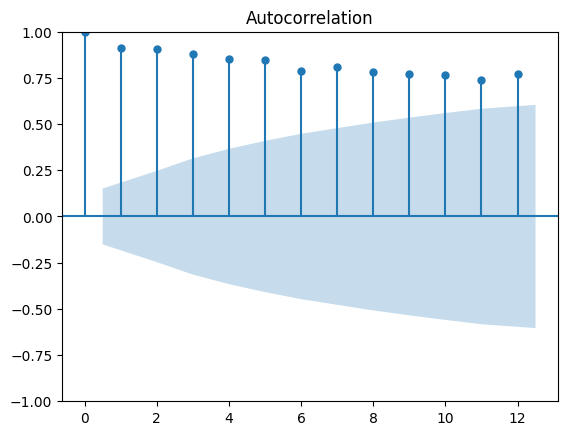

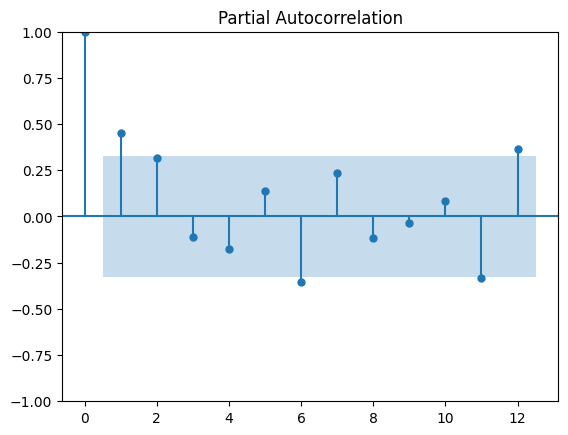

In [62]:
# examine autocorrelation
plot_acf(train['demanda'], lags = 12); print()
plot_pacf(test['demanda'], lags = 12); print()

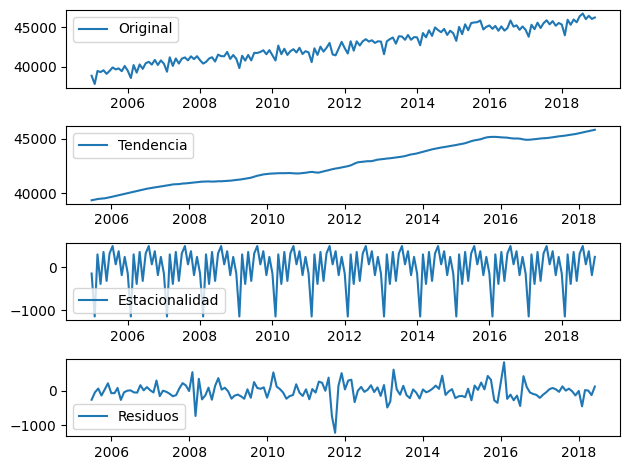

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie
decomposition = seasonal_decompose(train['demanda'])

# Gráficos de los componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train['demanda'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuos')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [82]:
train.columns

Index(['demanda', 'pib', 'pop', 'inflacion', 'temp', 'prep', 'dow', 'trimestre', 'prediction'], dtype='object')

In [101]:
exogenous_features=['pib','pop','inflacion','prep','temp']

In [102]:
model_autoARIMA = auto_arima(train['demanda'], exogenous=train[exogenous_features],
                      test='adf',
                      max_p= 7, max_q=7,          
                      d= 1,
                      m= 12,
                      D=1,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model_autoARIMA.fit(train['demanda'], exogenous=train[exogenous_features])

forecast = model_autoARIMA.predict(n_periods=len(test), exogenous=test[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2329.502, Time=1.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2377.169, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2348.217, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2336.296, Time=0.39 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=2336.473, Time=1.20 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=2343.110, Time=0.87 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=2337.262, Time=2.78 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=2340.964, Time=2.72 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=2356.272, Time=0.56 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=inf, Time=2.39 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=2340.298, Time=1.91 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(3,1,2)(1,1,1)[12]             : 

In [103]:
print(model_autoARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1157.751
Date:                              Mon, 22 May 2023   AIC                           2329.502
Time:                                      16:45:29   BIC                           2350.806
Sample:                                  01-01-2005   HQIC                          2338.155
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7464      0.214     -3.488      0.000      -1.166      -0.327
ar.L2         -0.14

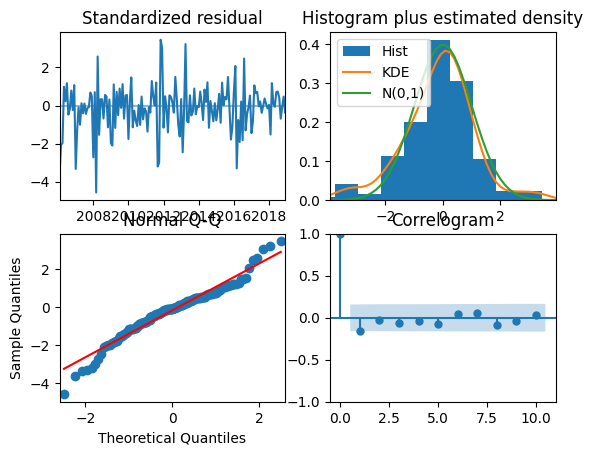

In [104]:
model_autoARIMA.plot_diagnostics()
plt.show()

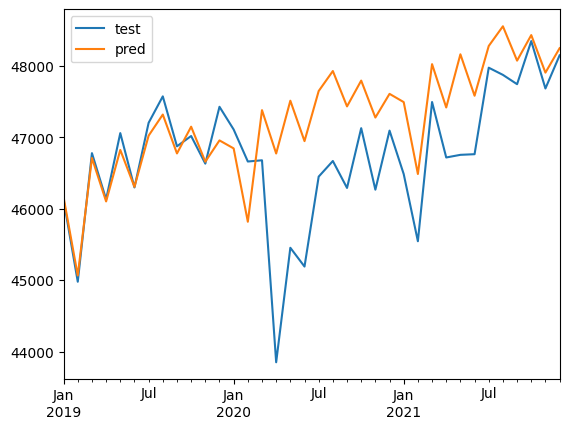

In [105]:
pred = model_autoARIMA.predict(n_periods=len(test), exogenous=test[exogenous_features])

pd.DataFrame({'test':test['demanda'],'pred':pred}).plot();plt.show()

In [113]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['demanda'], pred)
mae = mean_absolute_error(test['demanda'], pred)

rmse = np.sqrt(mean_squared_error(test['demanda'], pred))

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['demanda'], pred)


print(f"mse: {mse}")
print(f"mae: {mae}")
print(f"rmse: {rmse}")
print(f"mape:{mape}")
#en promedio, las predicciones tienen un error absoluto del 1.39% con respecto a los valores reales de la serie de tiempo.
#Representa la precisión relativa de las predicciones y se expresa como un porcentaje.

mse: 825581.650033904
mae: 642.0550716740896
rmse: 908.6152376192598
mape:1.3915806488000444


### Skforecast

In [26]:
# Crear y entrenar forecaster
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=train['demanda'])

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 167] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-21 13:45:48 
Last fit date: 2023-05-21 13:45:48 
Skforecast version: 0.7.0 
Python version: 3.10.9 
Forecaster id: None 

In [28]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)

6    46176.6
7    46127.6
8    46141.9
9    46137.4
10   46136.6
Name: pred, dtype: float64

In [30]:
fechas = pd.date_range(start='2019-01-01', end='2021-12-01', freq='MS')
# Crear el DataFrame con las dos columnas
df_predicciones = pd.DataFrame({'Fecha': fechas, 'predicciones': predicciones}).set_index('Fecha')

predicciones
Fecha                   
2019-01-01       46176.6
2019-02-01       46127.6
2019-03-01       46141.9
2019-04-01       46137.4
2019-05-01       46136.6
2019-06-01       46149.7
2019-07-01       46149.7
2019-08-01       46149.7
2019-09-01       46149.7
2019-10-01       46149.7
2019-11-01       46149.7
2019-12-01       46149.7
2020-01-01       46149.7
2020-02-01       46149.7
2020-03-01       46149.7
2020-04-01       46149.7
2020-05-01       46149.7
2020-06-01       46149.7
2020-07-01       46149.7
2020-08-01       46149.7
2020-09-01       46149.7
2020-10-01       46149.7
2020-11-01       46149.7
2020-12-01       46149.7
2021-01-01       46149.7
2021-02-01       46149.7
2021-03-01       46149.7
2021-04-01       46149.7
2021-05-01       46149.7
2021-06-01       46149.7
2021-07-01       46149.7
2021-08-01       46149.7
2021-09-01       46149.7
2021-10-01       46149.7
2021-11-01       46149.7
2021-12-01       46149.7

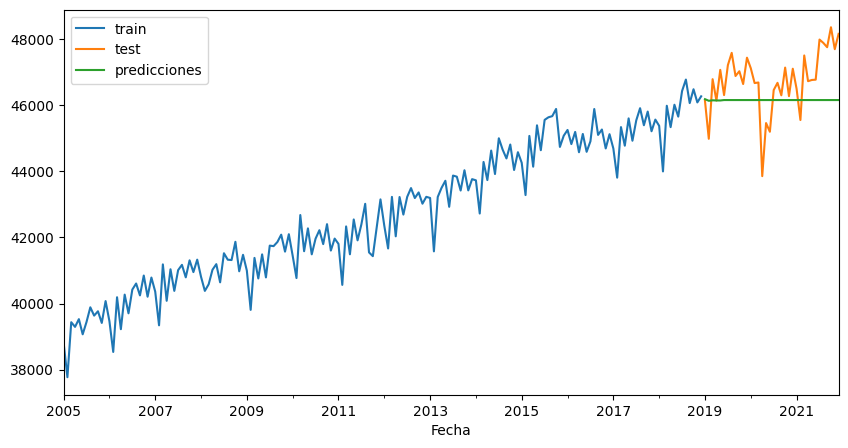

In [32]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
train['demanda'].plot(ax=ax, label='train')
test['demanda'].plot(ax=ax, label='test')
df_predicciones['predicciones'].plot(ax=ax, label='predicciones')
ax.legend();

In [33]:
from sklearn.metrics import mean_squared_error
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['demanda'],
                y_pred = df_predicciones['predicciones']
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 1188698.0241203727


In [34]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36

# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

# Lags utilizados como predictores
lags_grid = [10, 36]

# Hiperparámetros del regresor
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}


resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['demanda'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:03<00:00,  1.65s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1449044.0229900363



In [36]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

lags                                                         params  mean_squared_error  learning_rate  max_depth  n_estimators
19  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]    {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}           1449044.0            0.1        3.0         500.0
23  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]   {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}           1450302.9            0.1       10.0         500.0
21  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]    {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}           1450302.9            0.1        5.0         500.0
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]    {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}           1475696.6            0.1        5.0         100.0
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]   {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}           1475696.6            0.1       10.0         100.0
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]    {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}           1477143.5            0.1        3.0         100.0
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]   {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}           1558822.1            0.0        3.0         500.0
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}           1559763.6            0.0       10.0         500.0
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]   {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}           1559763.6            0.0        5.0         500.0
10                                                                                                          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}           1750222.4            0.1       10.0         100.0
6                                                                                                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]    {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}           1751437.4            0.1        3.0         100.0
8                                                                                                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]    {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}           1751574.4            0.1        5.0         100.0
1                                                                                                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}           1767511.6            0.0        3.0         500.0
3                                                                                                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}           1776152.8            0.0        5.0         500.0
5                                                                                                           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  {'learning_rate': 0.01, 'max_depth': 10, 'n_estim

In [37]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]
# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['demanda'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=train['demanda'])


# Predicciones
# ==============================================================================
steps=36
predicciones = forecaster.predict(steps=steps)


from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.18f}'.format
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['demanda'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:31<00:00, 15.84s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 1002029.6983015965

Error de test (mse): 1955647.6962960218


In [39]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

feature           importance
0    lag_1 0.009798466328308948
1    lag_2 0.010477503971350510
2    lag_3 0.025664841632712664
3    lag_4 0.015174334702375315
4    lag_5 0.013750803712272081
5    lag_6 0.000104135731234604
6    lag_7 0.016092808912590965
7    lag_8 0.017751620962488043
8    lag_9 0.005503172365216807
9   lag_10 0.017922769959900300
10  lag_11 0.001610259935405367
11  lag_12 0.788424105151206200
12  lag_13 0.005101389664562895
13  lag_14 0.021989213965541030
14  lag_15 0.000266253894781317
15  lag_16 0.008988935900817207
16  lag_17 0.024455859229585174
17  lag_18 0.000443342527261798
18  lag_19 0.006192796566399637
19  lag_20 0.010287384885989306

In [63]:
df.head()

demanda                      pib                  pop            inflacion                  temp                 prep  dow  trimestre
fecha                                                                                                                                               
2005-01-01  3946789849 40830.575228584537399001 1.109388183938130767 5.429999999999999716 22.609191074629691798 3.639948885601104855    5          1
2005-02-01  3708680486 42690.777948476148594636 1.114310388212953251 5.250000000000000000 22.778507415089087829 3.932040045708593112    1          1
2005-03-01  4089009176 43080.999913676307187416 1.118929943676315375 5.030000000000000249 23.292925365005533678 4.289887922698003564    1          1
2005-04-01  4056019772 43055.245685923648125026 1.123246854952591800 5.009999999999999787 23.204280031417898300 7.302988696306693228    4          2
2005-05-01  4110809403 42452.480921077847597189 1.127261126363138244 5.040000000000000036 22.897372920513831218 8.435269276571309760    6          2

In [66]:
df.index.max()

Timestamp('2021-12-01 00:00:00')

In [67]:
# Separación datos train-val-test
# ==============================================================================
datos = df.loc['2005-01-01 00:00:00': '2021-12-01 00:00:00']
fin_train = '2020-12-31 23:59:00'
fin_validacion = '2021-06-30 00:00:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2005-01-01 00:00:00 --- 2020-12-01 00:00:00  (n=192)
Fechas validacion : 2021-01-01 00:00:00 --- 2021-06-01 00:00:00  (n=6)
Fechas test       : 2021-07-01 00:00:00 --- 2021-12-01 00:00:00  (n=6)


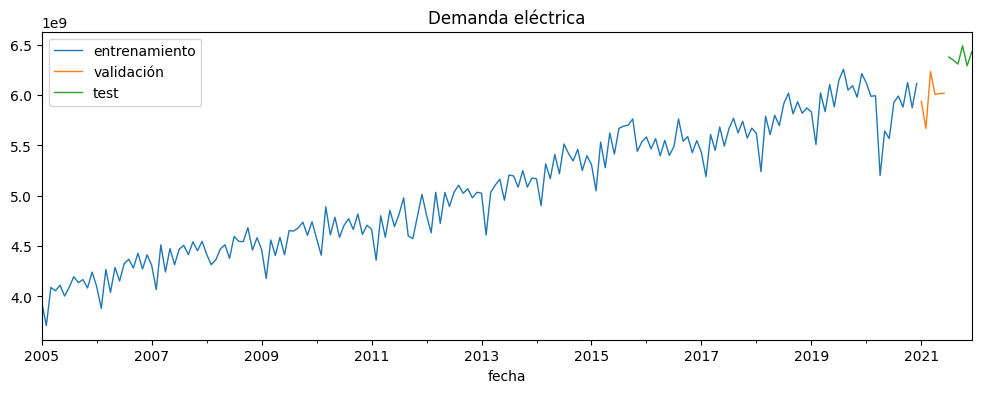

In [69]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.demanda.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.demanda.plot(ax=ax, label='validación', linewidth=1)
datos_test.demanda.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from skforecast.model_selection import backtesting_forecaster

# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()
             )


forecaster.fit(y=datos.loc[:fin_validacion, 'demanda'])
forecaster




# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.demanda,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()# Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'demanda'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(datos[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                  )


# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.demanda,
                            initial_train_size = len(datos[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            verbose            = False
                        )

# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')



Information of backtesting process
----------------------------------
Number of observations used for initial training: 198
Number of observations used for backtesting: 6
    Number of folds: 1
    Number of steps per fold: 24
    Last fold only includes 6 observations.

Data partition in fold: 0
    Training:   2005-01-01 00:00:00 -- 2021-06-01 00:00:00  (n=198)
    Validation: 2021-07-01 00:00:00 -- 2021-12-01 00:00:00  (n=6)

Error backtest: 98907435.13285463
Number of models compared: 30.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00, 12.53it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 78444958.75889969

Error backtest: 167186610.11577907


In [98]:
df.columns

Index(['demanda', 'pib', 'pop', 'inflacion', 'temp', 'prep', 'dow', 'trimestre'], dtype='object')

In [99]:
X = df.drop('demanda', axis = 1)
y = df['demanda']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, test_size = 0.2)

In [100]:
from pygam import LinearGAM
gam = LinearGAM(n_splines=10).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.1145
Link Function:                     IdentityLink Log Likelihood:                                 -7794.6703
Number of Samples:                          204 AIC:                                            15653.5696
                                                AICc:                                            15666.016
                                                GCV:                                2.1463770683891604e+16
                                                Scale:                              1.5665382942663684e+16
                                                Pseudo R-Squared:                                   0.9694
Feature Function                  Lam

<Figure size 640x480 with 0 Axes>

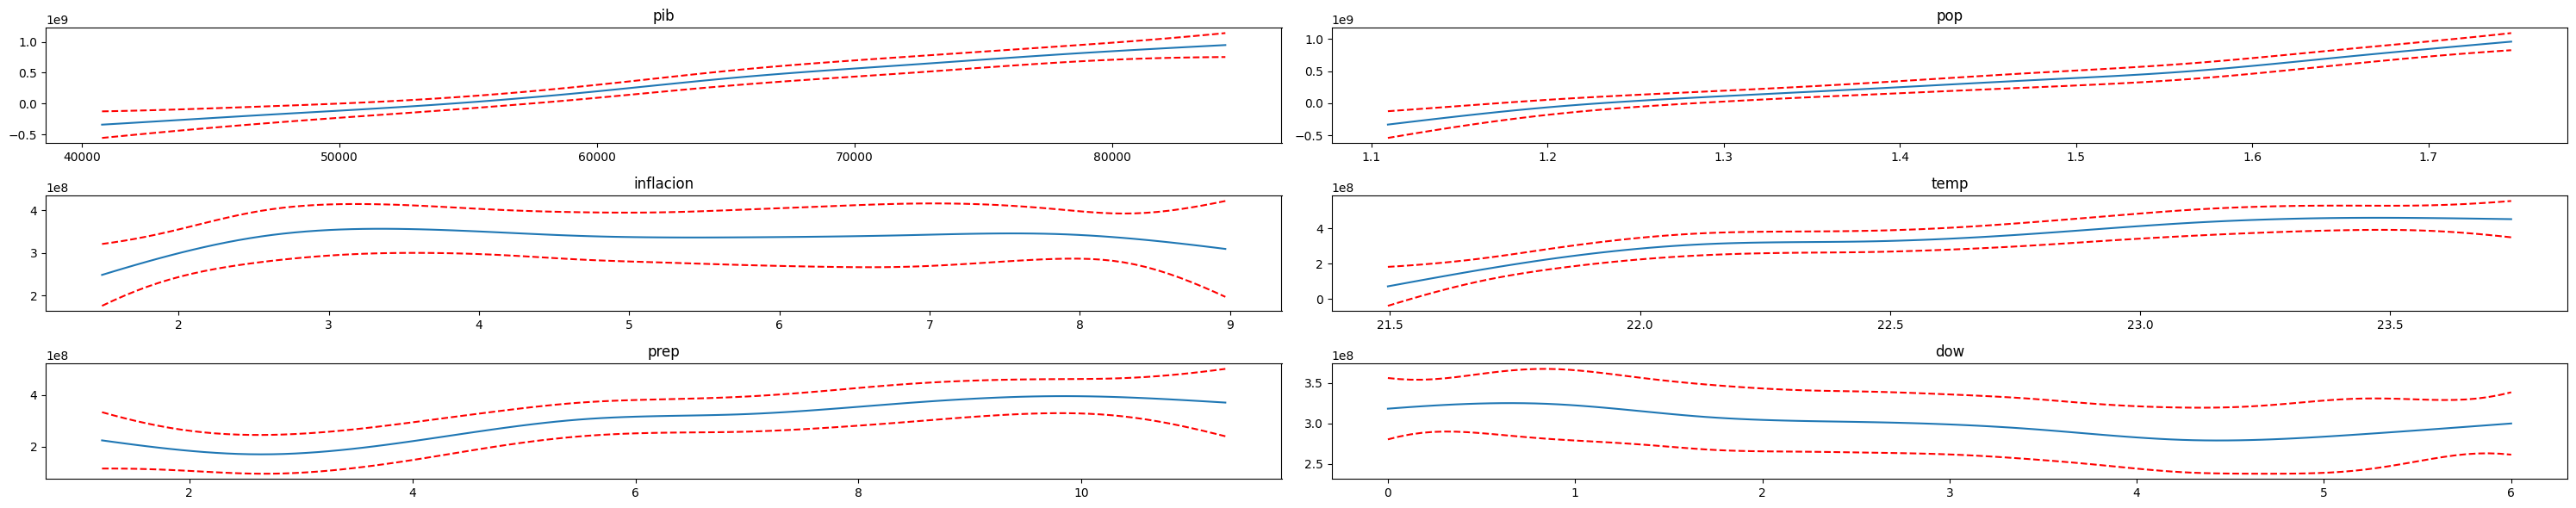

In [101]:
## plotting
plt.figure();
fig, axes = plt.subplots(3,ncols =int(len(X.columns)/3), figsize = (30, 6));

titles = X.columns
for i, (col,ax) in enumerate(zip(X.columns, axes.flatten())):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);
plt.tight_layout()

In [102]:
def model_train_evaluation(y, ypred, model_name): 
       
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()
    f.text(0.95, 0.06, 'AUTHOR: RINI CHRISTY',
         fontsize=12, color='green',
         ha='left', va='bottom', alpha=0.5);
    
    print('\n \n \n \n')
    fig,ax=plt.subplots(figsize=(15,8))
    plt.plot(y.values, lw = 4, label='Actual values', color = 'blue')
    plt.plot(ypred, label='Predicted values', color = 'red')
    plt.legend(loc='best')
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.show()


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of GAM with n_splines=10 : 88346898.43312742
Mean Squared Error(MSE) of GAM with n_splines=10 : 1.3276067260402372e+16
Root Mean Squared Error (RMSE) of GAM with n_splines=10 : 115221817.64059432
Mean absolute percentage error (MAPE) of GAM with n_splines=10 : 0.017496413855831457
Explained Variance Score (EVS) of GAM with n_splines=10 : 0.9694401250074021
R2 of GAM with n_splines=10 : 0.97

 


 
 
 



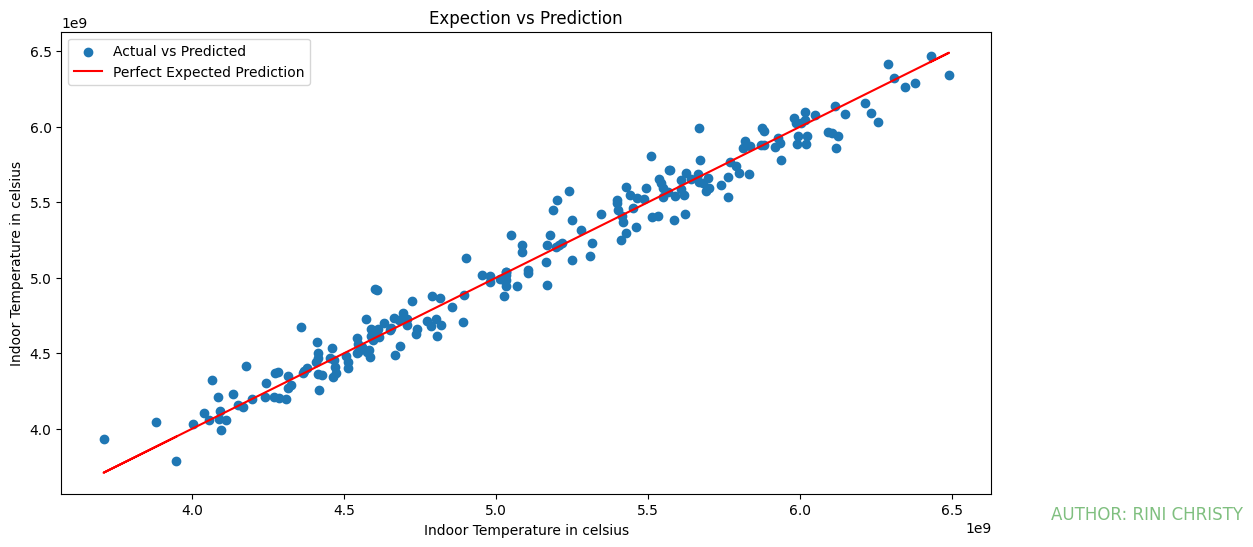

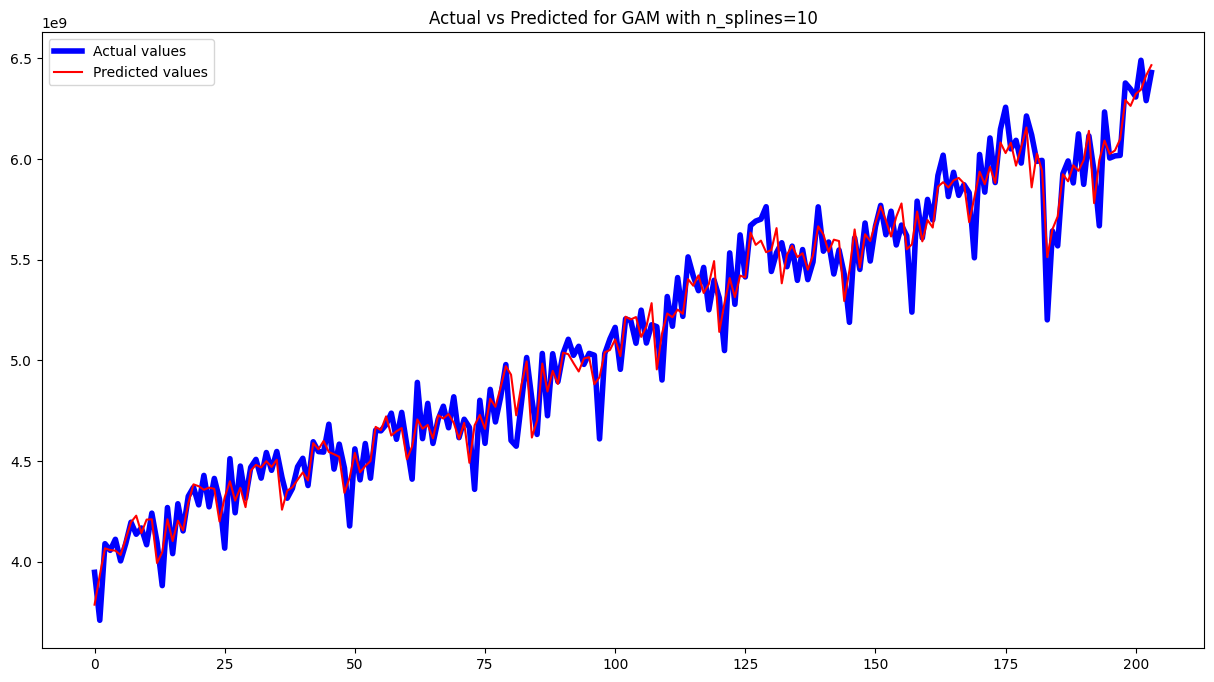

In [103]:
yhat = gam.predict(X)
model_train_evaluation(y, yhat, 'GAM with n_splines=10')

<Figure size 640x480 with 0 Axes>

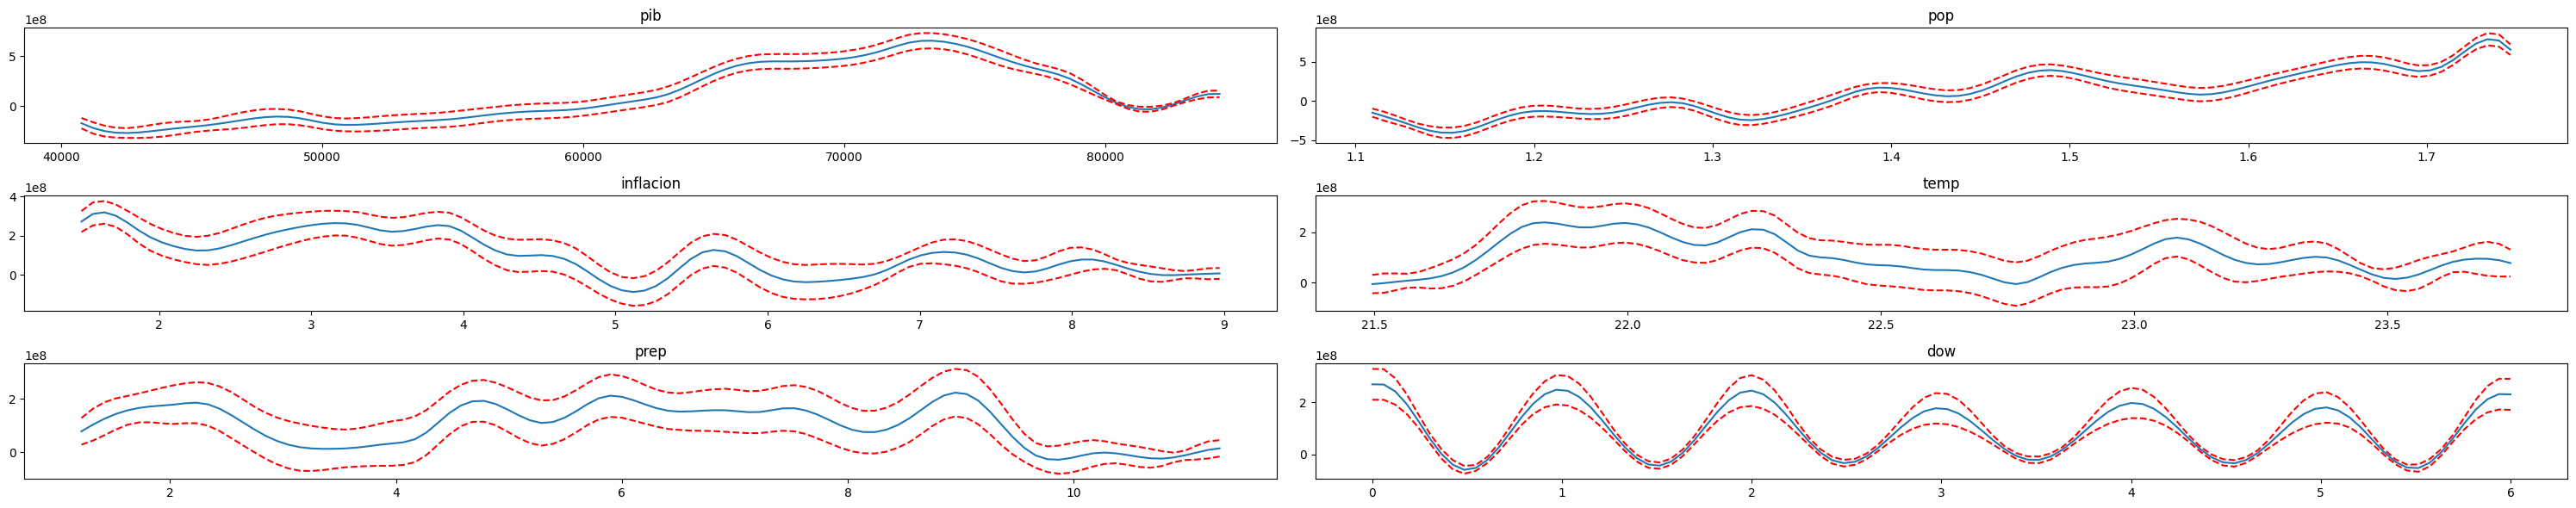

In [104]:
gam = LinearGAM(n_splines=40).fit(X, y)
## plotting
plt.figure();
fig, axes = plt.subplots(3,ncols =int(len(X.columns)/3), figsize = (30, 6));

titles = X.columns
for i, (col,ax) in enumerate(zip(X.columns, axes.flatten())):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #if i == 0:
        #ax.set_ylim(-30,30)
    ax.set_title(titles[i]);
plt.tight_layout()


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of GAM (n_splines=40) prediction using training set  : 108040515.95477502
Mean Squared Error(MSE) of GAM (n_splines=40) prediction using training set  : 2.0540337104676956e+16
Root Mean Squared Error (RMSE) of GAM (n_splines=40) prediction using training set  : 143319004.6877139
Mean absolute percentage error (MAPE) of GAM (n_splines=40) prediction using training set  : 0.021014945262901357
Explained Variance Score (EVS) of GAM (n_splines=40) prediction using training set  : 0.9527203261208648
R2 of GAM (n_splines=40) prediction using training set  : 0.95

 


 
 
 



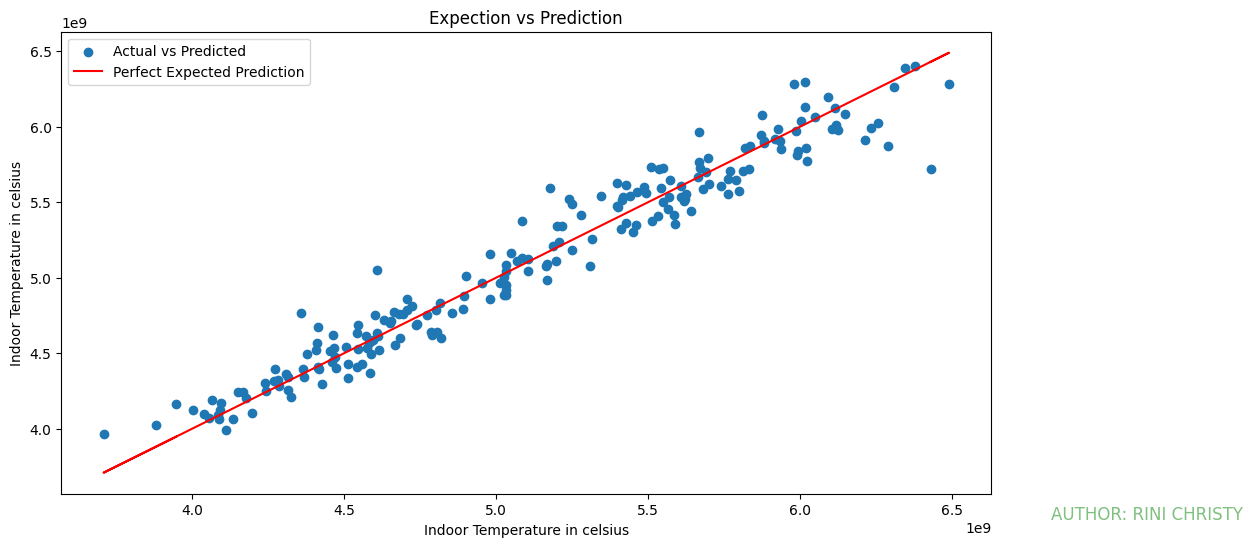

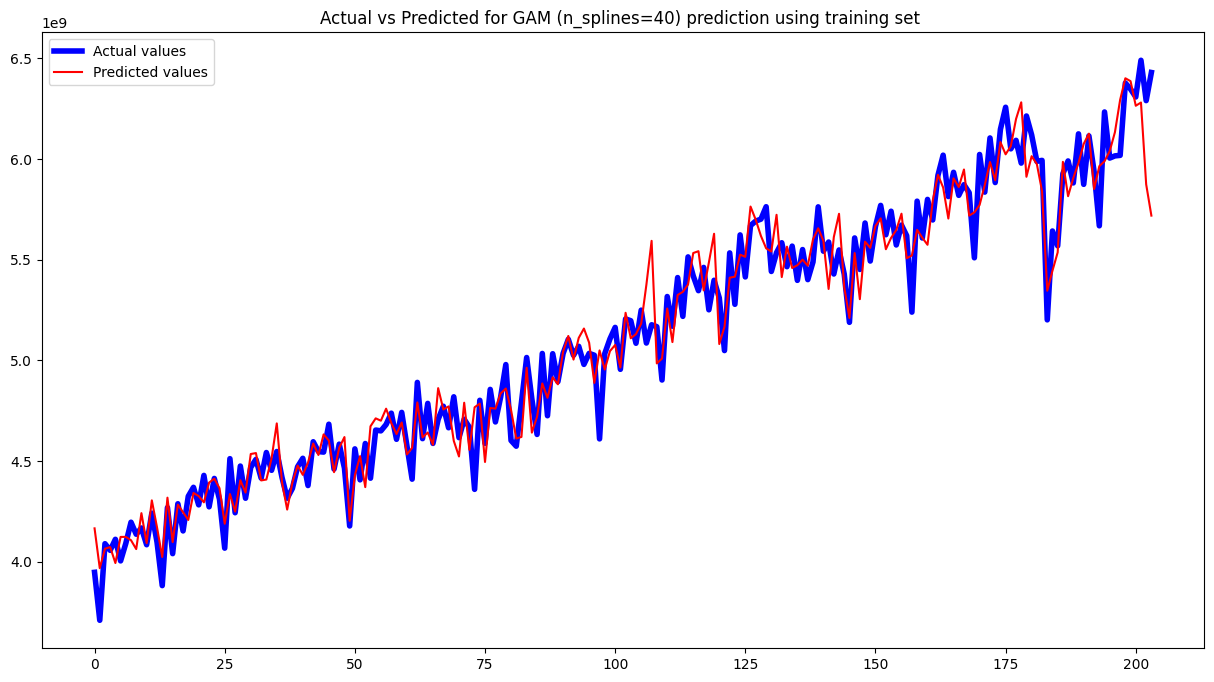

In [105]:
yhat = gam.predict(X)
model_train_evaluation(y, yhat, 'GAM (n_splines=40) prediction using training set ')


 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of GAM prediction using validation set : 96027419.47722442
Mean Squared Error(MSE) of GAM prediction using validation set : 1.4608753563446422e+16
Root Mean Squared Error (RMSE) of GAM prediction using validation set : 120866676.81146206
Mean absolute percentage error (MAPE) of GAM prediction using validation set : 0.018494915941580616
Explained Variance Score (EVS) of GAM prediction using validation set : 0.961792186527082
R2 of GAM prediction using validation set : 0.96

 


 
 
 



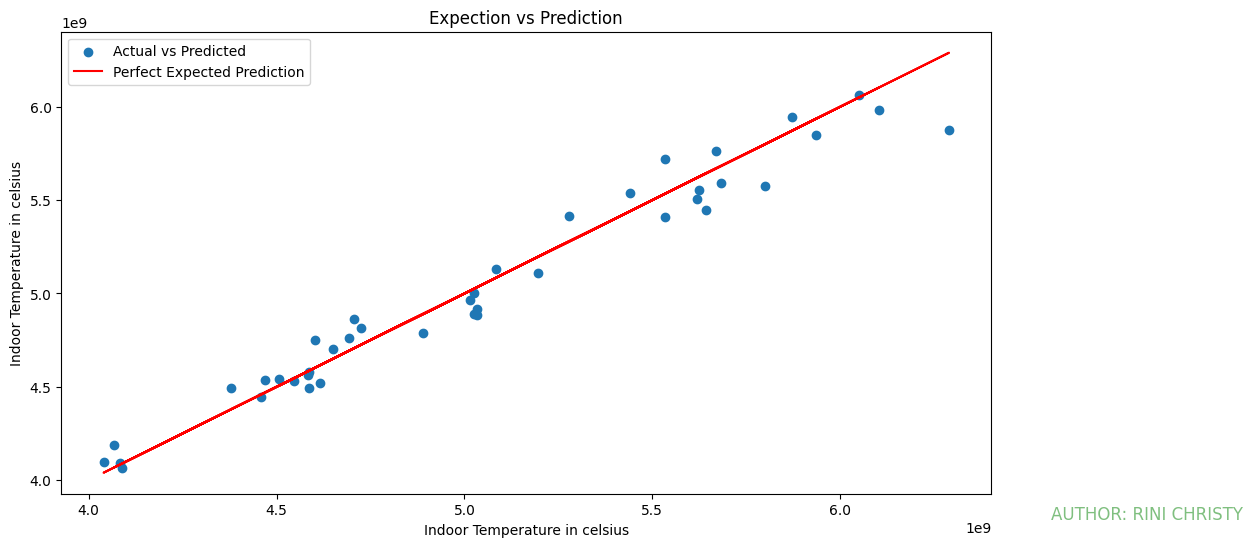

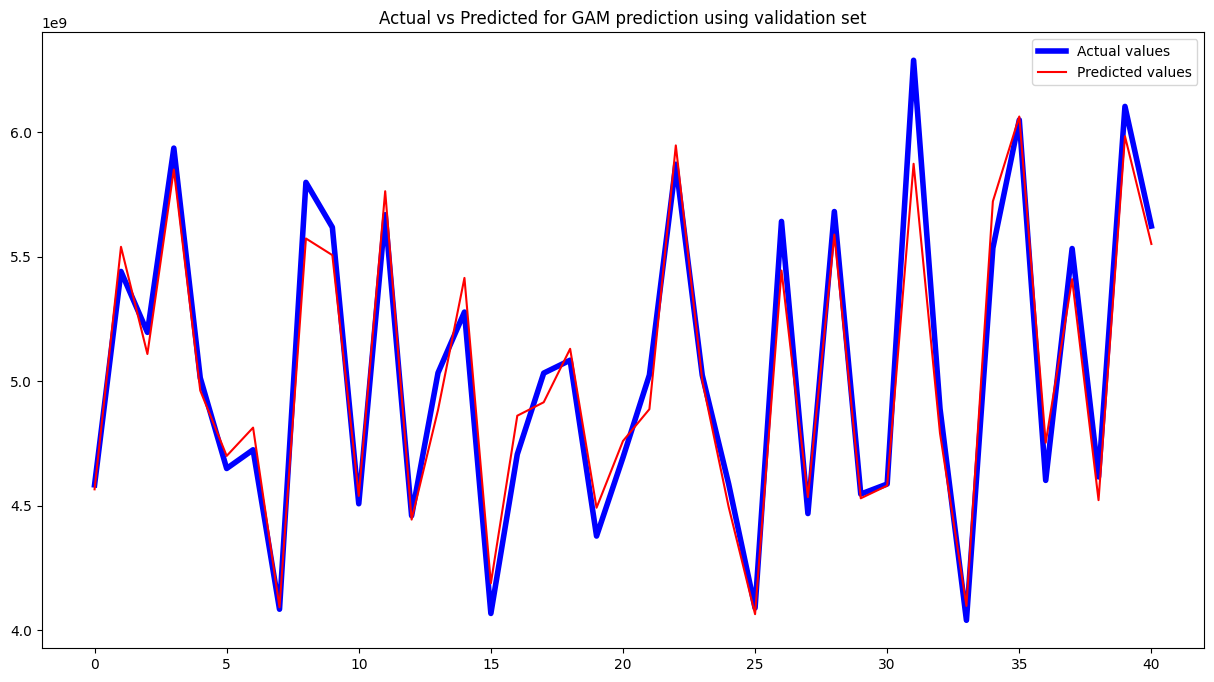

In [106]:
ypred = gam.predict(X_val)
model_train_evaluation(y_val, ypred, 'GAM prediction using validation set')

In [107]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       67.29
Link Function:                     IdentityLink Log Likelihood:                                 -7931.5942
Number of Samples:                          204 AIC:                                            15999.7683
                                                AICc:                                           16070.0202
                                                GCV:                                 7.091051081206868e+16
                                                Scale:                               3.065049058483427e+16
                                                Pseudo R-Squared:                                   0.9527
Feature Function                  Lam

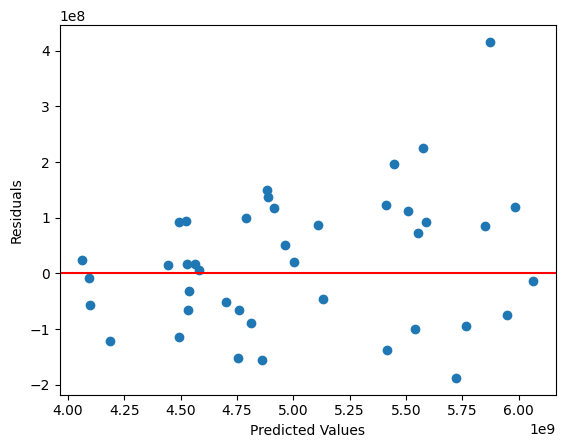

In [108]:
residuals = y_val.values-ypred
plt.scatter(ypred, residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [169]:
# Seleccionar la variable objetivo (demanda) y las covariables (pip, pop, inflacion, temp, prep)
target_var = 'demanda'
covar_vars = ['pib', 'pop', 'inflacion', 'temp', 'prep']
X = df[covar_vars].values
y = df[target_var].values

In [171]:
from sklearn.preprocessing import MinMaxScaler
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1,1))

In [172]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [173]:
# Preparar los datos para la LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [174]:
n_steps = 3
n_features = len(covar_vars)
train_data = np.column_stack((X_train, y_train))
test_data = np.column_stack((X_test, y_test))
X_train, y_train = prepare_data(train_data, n_steps)
X_test, y_test = prepare_data(test_data, n_steps)

In [176]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Definir la arquitectura de la LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [177]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
5/5 [==============================] - 2s 4ms/step - loss: 0.2086
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1618
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1215
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0863
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0567
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0348
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 8/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 9/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 10/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 11/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 12/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0124
Epoch 13/200
5/5 [==============================] - 0s 4ms/st

In [178]:
# Evaluar el modelo
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, np.sqrt(train_score)))
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, np.sqrt(test_score)))

Train Score: 0.00 MSE (0.04 RMSE)
Test Score: 0.01 MSE (0.09 RMSE)


### Alternativa

In [181]:
# Importar librerías
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


# Crear un dataframe con las covariables
covariates = ['pib', 'pop', 'inflacion', 'temp', 'prep']
X = df[covariates]

# Crear un dataframe con la variable objetivo
y = df['demanda']

# Escalar los datos
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

# Definir la ventana de tiempo
look_back = 12

# Preparar los datos para LSTM
X_lstm = []
y_lstm = []
for i in range(look_back, len(X)):
    X_lstm.append(X_scaled[i-look_back:i, :])
    y_lstm.append(y_scaled[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Dividir el dataset en conjuntos de entrenamiento y prueba
train_size = int(len(X_lstm) * 0.8)
test_size = len(X_lstm) - train_size
X_train, X_test = X_lstm[0:train_size,:,:], X_lstm[train_size:len(X_lstm),:,:]
y_train, y_test = y_lstm[0:train_size], y_lstm[train_size:len(y_lstm)]

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Hacer las predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertir las transformaciones de escalamiento
train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, test_predict)
print("Mean Squared Error:", mse)

# Crear una matriz de datos para hacer nuevas predicciones
X_new = X_scaled[-look_back:]
X_new = X_new.reshape((1, look_back, X_new.shape[1]))

# Hacer una nueva predicción
y_new = model.predict(X_new)
y_new = scaler_y.inverse_transform(y_new)
print("Predicción para el próximo periodo:", y_new[0][0])


Epoch 1/100
3/3 - 3s - loss: 0.2053 - val_loss: 0.5152 - 3s/epoch - 980ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0866 - val_loss: 0.2681 - 80ms/epoch - 27ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0300 - val_loss: 0.1131 - 72ms/epoch - 24ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0240 - val_loss: 0.0424 - 72ms/epoch - 24ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0435 - val_loss: 0.0235 - 84ms/epoch - 28ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0530 - val_loss: 0.0233 - 72ms/epoch - 24ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0447 - val_loss: 0.0323 - 80ms/epoch - 27ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0318 - val_loss: 0.0474 - 77ms/epoch - 26ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0229 - val_loss: 0.0621 - 73ms/epoch - 24ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0186 - val_loss: 0.0703 - 64ms/epoch - 21ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0163 - val_loss: 0.0697 - 64ms/epoch - 21ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0144 - val_loss: 0.0615 - 72ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0125 -

### ARIMAX

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Separar los datos en train y test
train = df.loc['2005-01-01':'2019-12-01']
test = df.loc['2020-01-01':]

# Seleccionar las columnas relevantes para el modelo
train_demand = train['demanda']
train_covariates = train[['pib', 'pop', 'inflacion', 'temp', 'prep']]

# Ajustar el modelo ARIMAX
model = ARIMA(train_demand, order=(1, 1, 1), exog=train_covariates)
fit = model.fit()

# Predecir con las covariables
test_covariates = test[['pib', 'pop', 'inflacion', 'temp', 'prep']]
predictions = fit.predict(start=test.index[0], end=test.index[-1], exog=test_covariates)



### RNN

In [125]:
steps = 36
train = df[:-steps]
test  = df[-steps:]

In [126]:
train_X = train.drop('demanda', axis = 1)
train_y = train['demanda']

test_X = test.drop('demanda', axis = 1)
test_y = test['demanda']

In [130]:
# Normalizar los datos
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [131]:
# Ajustar la forma de los datos para ser utilizados en la red neuronal convolucional
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [153]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D

# Definir la arquitectura de la red neuronal convolucional
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_X.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

In [154]:
# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Ajustar el modelo a los datos de entrenamiento
model.fit(train_X, train_y, epochs=100, batch_size=64, verbose=0)

# Evaluar el modelo en los datos de prueba
mse = model.evaluate(test_X, test_y, verbose=0)
print('Mean Squared Error:', mse)

Mean Squared Error: 3.622303454410362e+19
